# **Customer Churn Predictor**

## **<span style="color: blue;">Business Understanding</span>**

Train a model to predict the likelihood of a customer leaving the organization, the key indicators of churn as well as the retention strategies that can be implemented to avert this problem.

The likelihood of a customer leaving the organization (churn) is influenced by a combination of factors, including:

1. Demographic characteristics (Gender, SeniorCitizen)
2. Account characteristics (Tenure, Phone Service, MultipleLines, InternetService)
3. Service features (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies)
4. Billing and payment characteristics (Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges)


**Hypothesis**

**Null Hypothesis (H0):**

There is no significant relationship between the identified factors (demographic characteristics, account characteristics, service features, and billing and payment characteristics) and customer churn.

**Alternative Hypothesis (H1):**

There is a significant relationship between the identified factors and customer churn, and the likelihood of churn can be predicted by a combination of these factors.



**Questions**

1. Is there a significant difference in churn rates between customers with a tenure of less than 12 months and those with a tenure of 12 months or more?

2. Do customers with online security and backup features have a lower churn rate compared to those without these features?

3. Is there a correlation between monthly charges and churn, and what is the threshold beyond which the likelihood of churn increases significantly?


**Additional Questions**

1. Do customers with multiple lines (MultipleLines = Yes) have a lower churn rate compared to those with a single line?

2. Is there a significant difference in churn rates between customers with different types of internet service (DSL, Fiber Optic, No)?

3. Does the presence of dependents (Dependents = Yes) increase the likelihood of churn?

4. Is there a correlation between the total charges (TotalCharges) and churn, and what is the threshold beyond which the likelihood of churn increases significantly?

5. Do customers with paperless billing (PaperlessBilling = Yes) have a lower churn rate compared to those without paperless billing?

6. Is there a significant difference in churn rates between customers with different payment methods (Electronic check, Mailed check, Bank transfer, Credit card)?

7. Does the length of the contract (Contract = Month-to-Month, One year, Two year) impact the likelihood of churn?




## **<span style="color: blue;">Data Understanding</span>**

### **<span style="color: skyblue;">Importation</span>**

**Importation of all necessary packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import chi2_contingency   
from scipy.stats import pointbiserialr
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif  
from sklearn.model_selection import GridSearchCV




#### **<span style="color: red;">1. Training Data</span>**

**Dataset Importation & Loading**

In [2]:
# Connect to the Database Using "pyodbc"
import pyodbc
print("pyodbc is installed and imported successfully")

import pyodbc
from dotenv import dotenv_values    #import the dotenv_values function from the dotenv package
import pandas as pd
import warnings 

warnings.filterwarnings('ignore')

# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials set in the '.env' file
server = environment_variables.get("SERVER_NAME")
database = environment_variables.get("DATABASE_NAME")
login = environment_variables.get("LOGIN")
password = environment_variables.get("PASSWORD")

pyodbc is installed and imported successfully


In [3]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={login};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"


In [4]:
# connect to the Database
connection = pyodbc.connect(connection_string)
print("Connection successful")


Connection successful


In [5]:
# Query the Sql Database
query = "SELECT * FROM dbo.LP2_Telco_churn_first_3000"

# Execute the query and read the results into a DataFrame
train_data = pd.read_sql(query, connection)


In [6]:
train_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [7]:
train_data.to_excel('output.xlsx', index=False)


### **<span style="color: skyblue;">Exploratory Data Analysis</span>**

**Data Quality Assessment & Exploring data**

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [9]:
# Checking for the sum of null values

print (train_data.isnull().sum())

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64


In [10]:
# Checking for the sum of duplicated values

train_data.duplicated().sum()

np.int64(0)

In [11]:
# Checking if the training dataset (Numerical) is evenly distributed (Summary Statistics)

train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,3000.0,32.527333,24.637768,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,3000.0,65.347400,30.137053,18.400000,35.787499,70.900002,90.262501,118.650002
TotalCharges,2995.0,2301.278315,2274.987884,18.799999,415.250000,1404.650024,3868.725098,8564.750000


In [12]:
# Summary Statistics for Categorical

train_data.describe(include=['object', 'bool']).T

,count,unique,top,freq
customerID,3000,3000,1A1:U3001038-RQOST,1
gender,3000,2,Male,1537
SeniorCitizen,3000,2,False,2525
Partner,3000,2,False,1538
Dependents,3000,2,False,2070
PhoneService,3000,2,True,2731
MultipleLines,2731,2,False,1437
InternetService,3000,3,Fiber optic,1343
OnlineSecurity,2349,2,False,1478
OnlineBackup,2349,2,False,1320


In [13]:
# Checking the Columns for Unique values

columns = train_data.columns

for column in columns:
    print (f'{column}')
    print (f'There are {train_data[column].unique().size} unique values')
    print (f'There are {train_data[column].unique()}')
    print ('=' * 50)

customerID
There are 3000 unique values
There are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '1891-FZYSA' '4770-UEZOX'
 '1A1:U3001038-RQOST']
gender
There are 2 unique values
There are ['Female' 'Male']
SeniorCitizen
There are 2 unique values
There are [False  True]
Partner
There are 2 unique values
There are [ True False]
Dependents
There are 2 unique values
There are [False  True]
tenure
There are 73 unique values
There are [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService
There are 2 unique values
There are [False  True]
MultipleLines
There are 3 unique values
There are [None False True]
InternetService
There are 3 unique values
There are ['DSL' 'Fiber optic' 'No']
OnlineSecurity
There are 3 unique values
There are [False True None]
OnlineBackup
There are 3 unique values
There are [True False None]

#### **<span style="color: skyblue;">Univariate Analysis</span>**

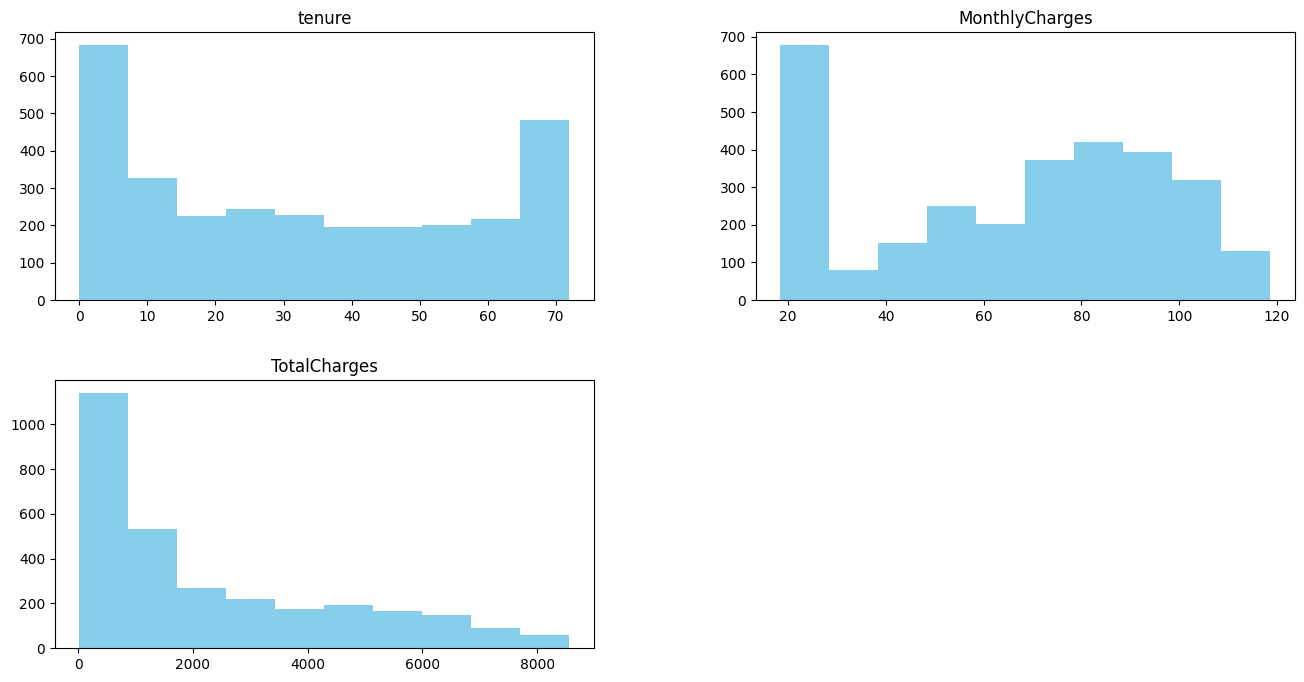

In [14]:
#Numerical Columns

train_data.hist(figsize= (16,8), grid=False, color='skyblue')
plt.title ('Numerical Features Distributions')
plt.show()

<Axes: ylabel='Density'>

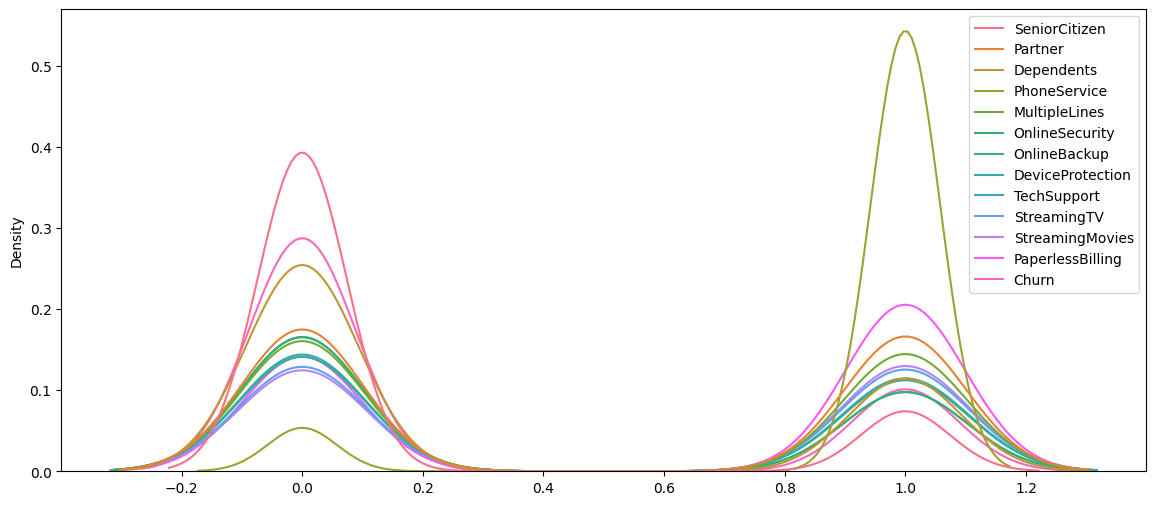

In [15]:
# Check if the datasets are evenly distributed

plt.figure(figsize = (14,6))
sns.kdeplot(train_data.drop(['TotalCharges', 'MonthlyCharges','tenure'],axis=1))


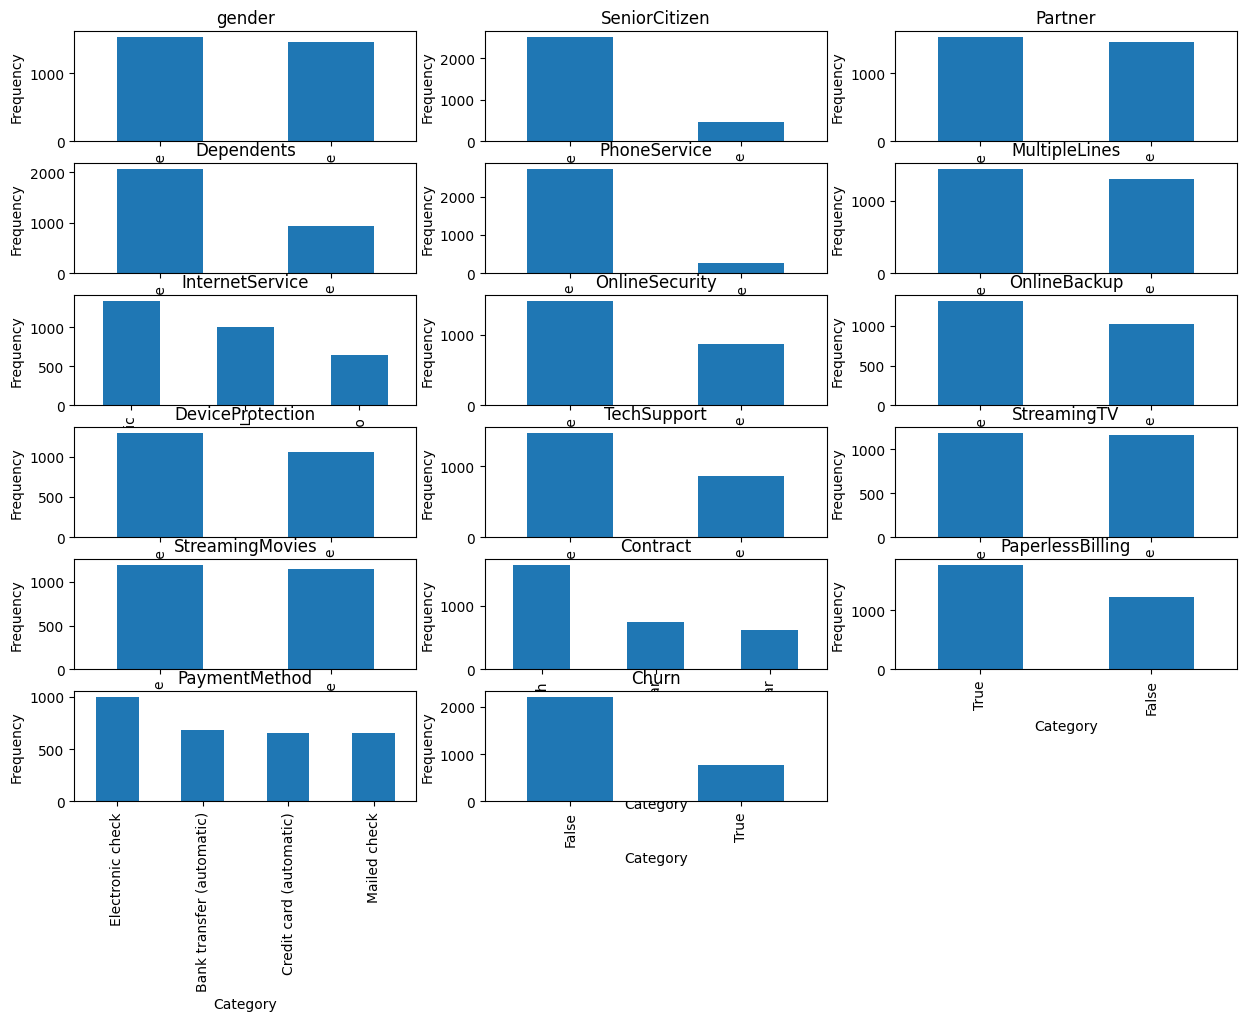

In [16]:
# Categorical Columns

# Define the figure size
plt.figure(figsize=(15, 10))

# Loop through each categorical variable
for i, var in enumerate(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']):
	# Create a subplot for each variable
	plt.subplot(6, 3, i+1)
	# Get the value counts
	counts = train_data[var].value_counts()
	# Plot the bar chart
	counts.plot(kind='bar')
	# Set the title and labels
	plt.title(var)
	plt.xlabel('Category')
	plt.ylabel('Frequency')

# Layout and show the plot
plt.tight_layout()
plt.show()


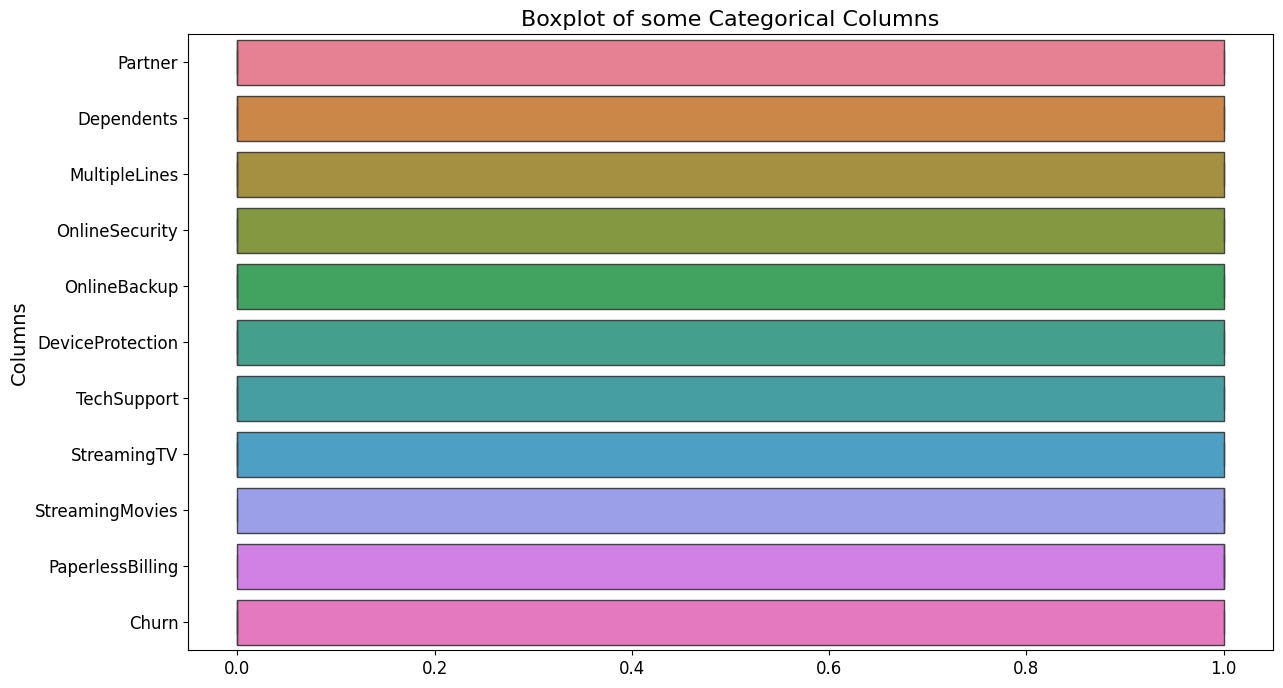

In [17]:
# Check for outliers

plt.figure(figsize=(14, 8))
plt.title("Boxplot of some Categorical Columns", fontsize=16)
sns.boxplot(train_data.drop(['TotalCharges', 'MonthlyCharges','tenure','SeniorCitizen','PhoneService'], axis=1), orient = 'h', showfliers=True)
plt.ylabel("Columns", fontsize=14)
plt.tick_params(labelsize=12)
plt.show()

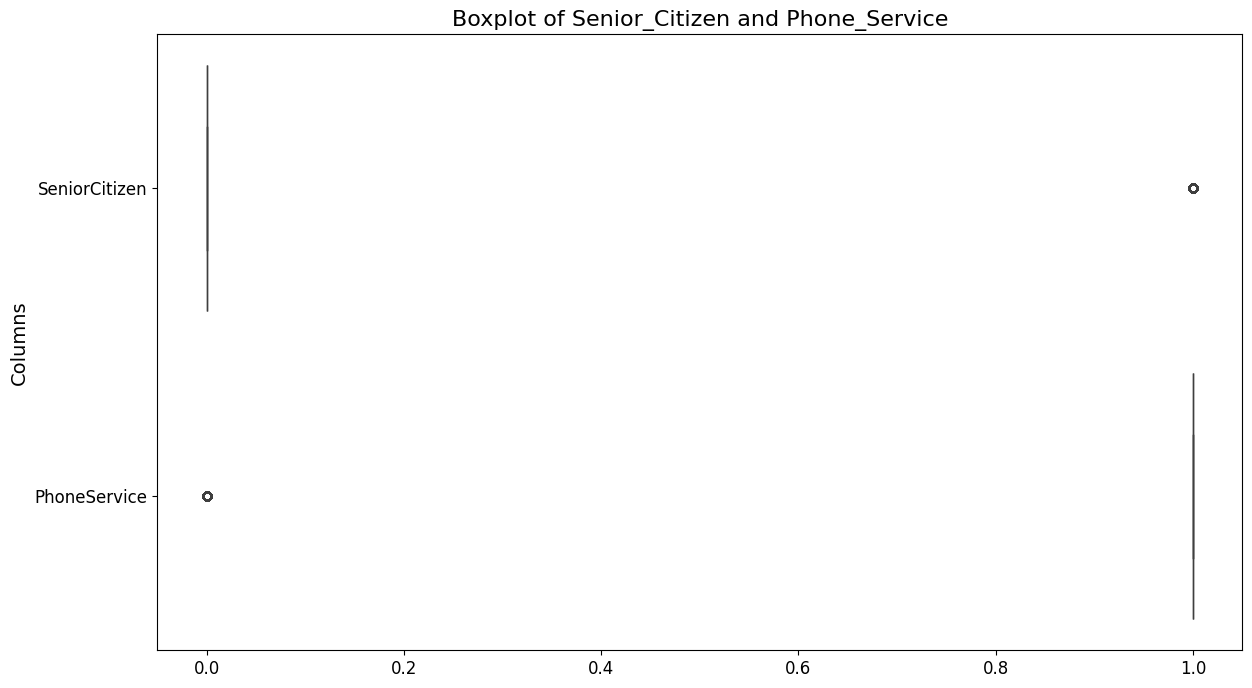

In [18]:
# Check for outliers (contd)

plt.figure(figsize=(14, 8))
plt.title("Boxplot of Senior_Citizen and Phone_Service", fontsize=16)
sns.boxplot(train_data[['SeniorCitizen','PhoneService']], orient = 'h', showfliers=True)
plt.ylabel("Columns", fontsize=14)
plt.tick_params(labelsize=12)
plt.show()

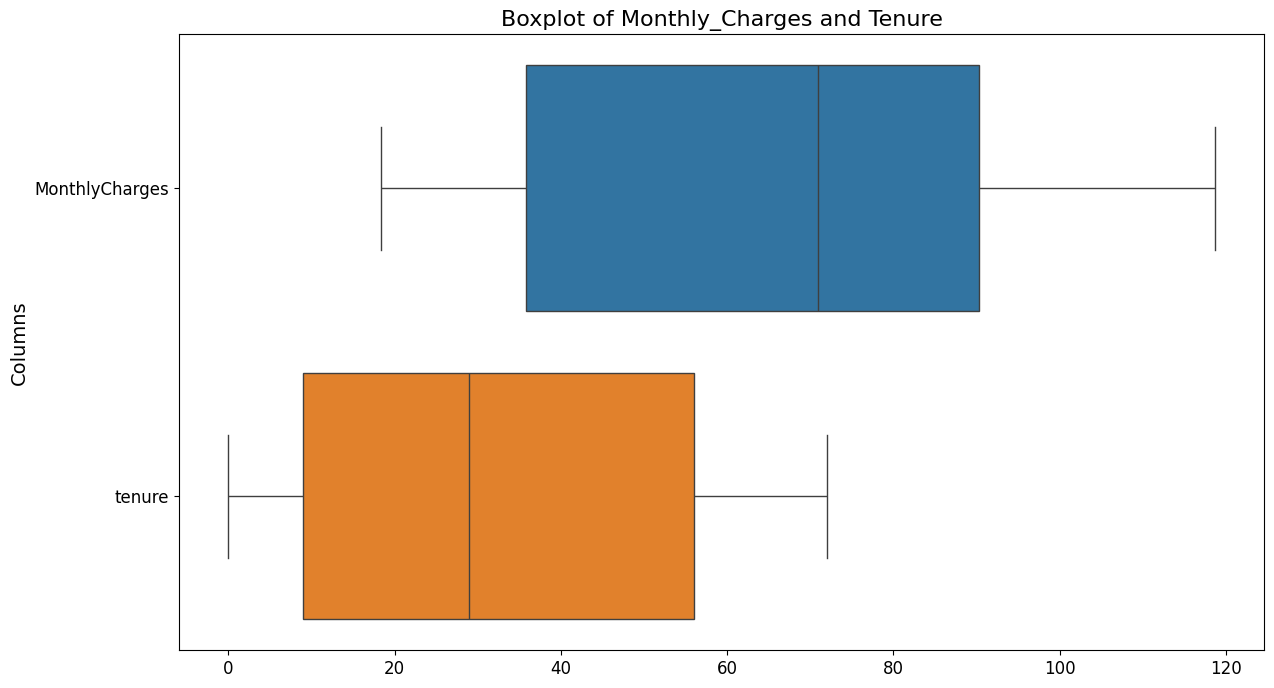

In [19]:
# Check for outliers (contd)

plt.figure(figsize=(14, 8))
plt.title("Boxplot of Monthly_Charges and Tenure", fontsize=16)
sns.boxplot(train_data[['MonthlyCharges','tenure']], orient = 'h', showfliers=True)
plt.ylabel("Columns", fontsize=14)
plt.tick_params(labelsize=12)
plt.show()



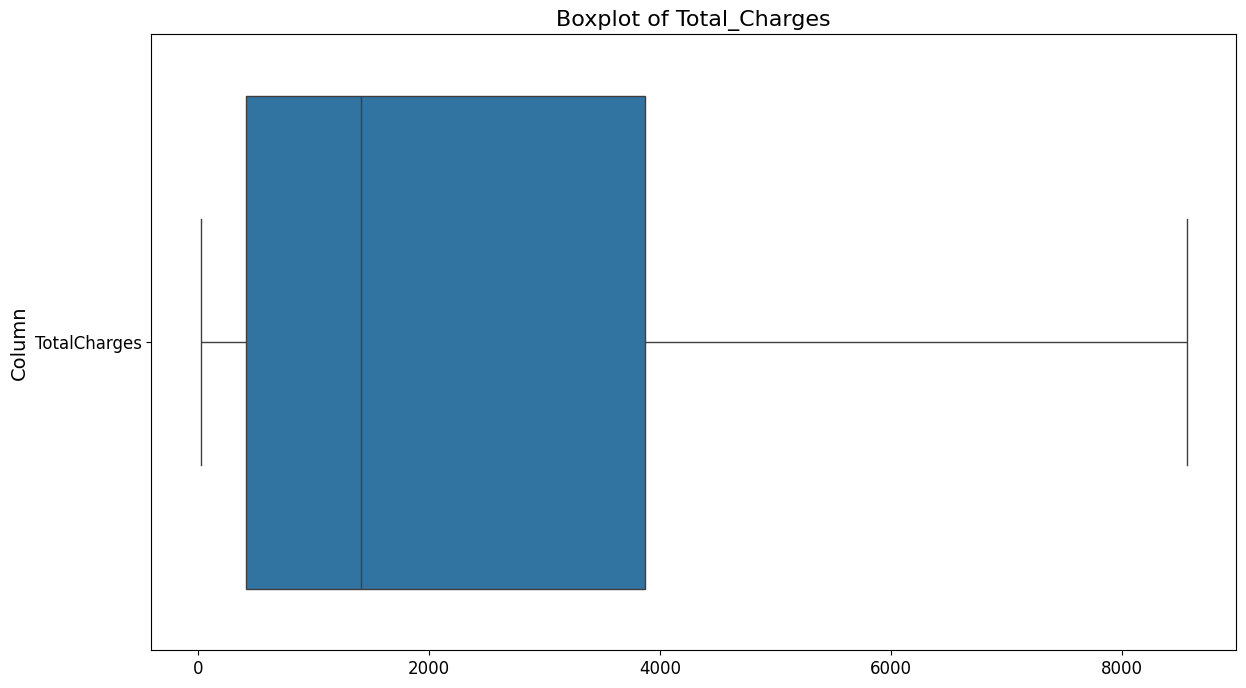

In [20]:
# Check for outliers (contd)

plt.figure(figsize=(14, 8))
plt.title("Boxplot of Total_Charges", fontsize=16)
sns.boxplot(train_data[['TotalCharges']], orient = 'h', showfliers=True)
plt.ylabel("Column", fontsize=14)
plt.tick_params(labelsize=12)
plt.show()



#### **<span style="color: skyblue;">Bivariate Analysis</span>**

In [21]:
#Check the correlation

correlation= train_data.corr(numeric_only = True)

correlation


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.006424,-0.197925,-0.014067,0.017871,0.159411,0.222478,0.084392
Partner,0.006424,1.000000,0.476960,0.383231,0.014221,0.006101,0.091626,0.326662
Dependents,-0.197925,0.476960,1.000000,0.183903,-0.014152,-0.109342,-0.100752,0.096310
tenure,-0.014067,0.383231,0.183903,1.000000,0.014154,0.006070,0.230240,0.824273
PhoneService,0.017871,0.014221,-0.014152,0.014154,1.000000,0.012459,0.240757,0.110220
PaperlessBilling,0.159411,0.006101,-0.109342,0.006070,0.012459,1.000000,0.351075,0.159661
MonthlyCharges,0.222478,0.091626,-0.100752,0.230240,0.240757,0.351075,1.000000,0.641280
TotalCharges,0.084392,0.326662,0.096310,0.824273,0.110220,0.159661,0.641280,1.000000


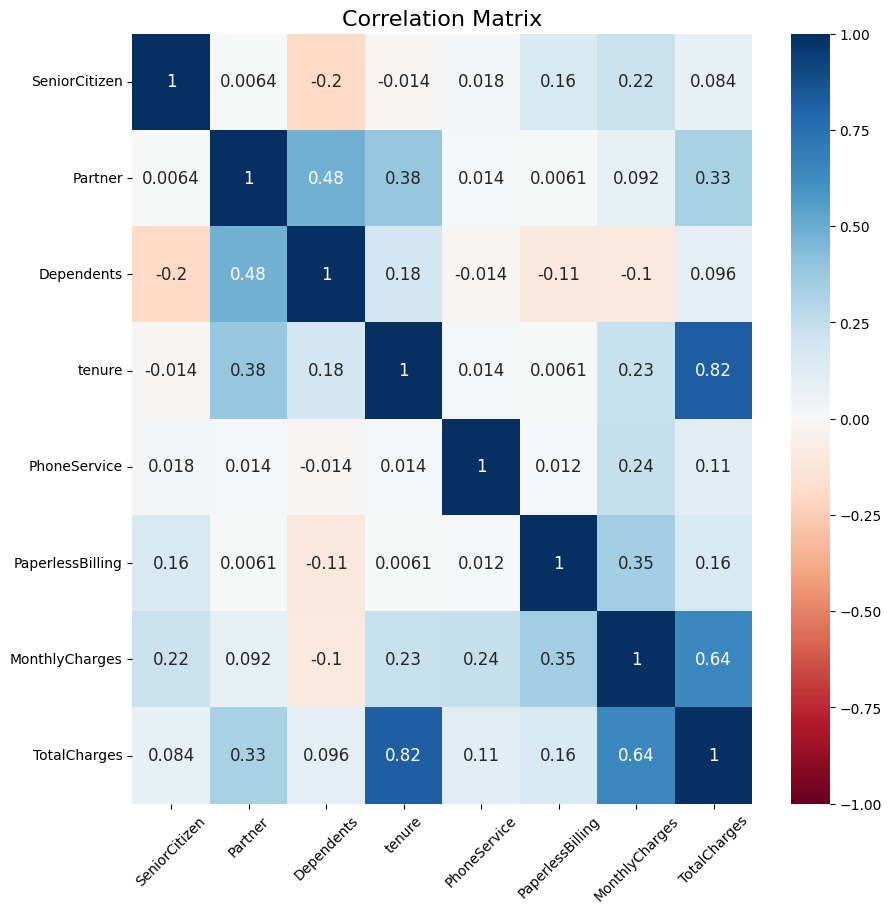

In [22]:
# Visualize the correlation

plt.figure(figsize=(10,10))
plt.title("Correlation Matrix", fontsize=16)
sns.heatmap(correlation, annot=True, cmap= 'RdBu', vmin=-1, vmax=1, annot_kws={'fontsize': 12})
plt.xticks(rotation=45)
plt.show()

**Handle missing values with SimpleImputer**

In [23]:
# Fill missing values for categorical columns with the mode
categorical_columns = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
imputer_cat = SimpleImputer(strategy='most_frequent')
train_data[categorical_columns] = imputer_cat.fit_transform(train_data[categorical_columns])

# Fill missing values for numerical columns with the mean
numerical_columns = ['TotalCharges']
imputer_num = SimpleImputer(strategy='mean')
train_data[numerical_columns] = imputer_num.fit_transform(train_data[numerical_columns])

# Fill missing value in 'Churn' column with mode (This is handled separately to avoid bias in the target variable)
train_data['Churn'].fillna(train_data['Churn'].mode()[0], inplace=True)


#### **<span style="color: skyblue;">Hypothesis Testing</span>**

In [24]:
categorical_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

results = {}

for var in categorical_vars:
    contingency_table = pd.crosstab(train_data[var], train_data['Churn'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    results[var] = {'chi2': chi2, 'p_value': p_value, 'dof': dof}

# Convert 'results' to a DataFrame 
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('p_value')
print(results_df)

                        chi2        p_value  dof
Contract          543.414411  9.978380e-119  2.0
InternetService   366.549263   2.540030e-80  2.0
PaymentMethod     281.487000   1.009436e-60  3.0
TechSupport       226.753172   3.043989e-51  1.0
OnlineSecurity    190.782435   2.145577e-43  1.0
PaperlessBilling  111.610046   4.349779e-26  1.0
OnlineBackup       95.327278   1.613741e-22  1.0
Dependents         88.111280   6.187378e-21  1.0
DeviceProtection   82.398194   1.112554e-19  1.0
Partner            60.778469   6.387272e-15  1.0
SeniorCitizen      60.114470   8.949797e-15  1.0
MultipleLines       4.275456   3.866659e-02  1.0
StreamingTV         3.189767   7.410058e-02  1.0
StreamingMovies     0.746671   3.875323e-01  1.0
PhoneService        0.418416   5.177286e-01  1.0
gender              0.067501   7.950114e-01  1.0


Given the chi-square test results, we can confidently reject the null hypothesis (H0) and accept the alternative hypothesis (H1). 

Here's why:

1. Significant Relationships: The majority of the tested factors (12 out of 16) show statistically significant relationships with customer churn, as evidenced by their p-values being less than 0.05.
2. Strong Evidence: Many factors, particularly Contract, InternetService, PaymentMethod, TechSupport, and OnlineSecurity, show extremely strong relationships with churn (p-values < 1e-40), providing robust evidence against the null hypothesis.
3. Varied Factors: The significant factors span across different categories including:
Account characteristics (e.g., Contract, InternetService)
Service features (e.g., TechSupport, OnlineSecurity, OnlineBackup)
Billing characteristics (e.g., PaymentMethod, PaperlessBilling)
Demographic characteristics (e.g., SeniorCitizen, Dependents, Partner)
4. Predictive Potential: The strong relationships observed suggest that these factors can be used to predict the likelihood of churn, supporting the second part of the alternative hypothesis.
5. Non-Significant Factors: While some factors (StreamingTV, StreamingMovies, PhoneService, gender) did not show significant relationships, this does not negate the overall conclusion. It's common in such analyses for some factors to be non-significant.

#### **<span style="color: skyblue;">Analytical Questions</span>**

1. Is there a significant difference in churn rates between customers with a tenure of less than 12 months and those with a tenure of 12 months or more?

Tenure_Group
< 12 months    46.849943
≥ 12 months    17.442407
Name: True, dtype: float64


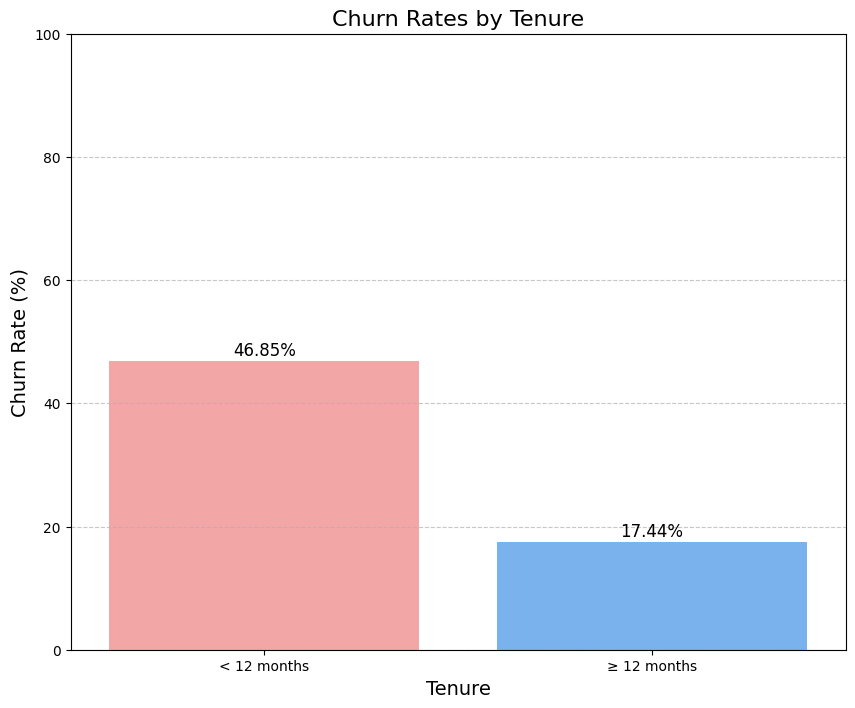

In [25]:

# Create a new column 'Tenure_Group'
train_data['Tenure_Group'] = train_data['tenure'].apply(lambda x: '< 12 months' if x < 12 else '≥ 12 months')

# Calculate churn rates
churn_rates = train_data.groupby('Tenure_Group')['Churn'].value_counts(normalize=True).unstack() * 100
churn_rates = churn_rates[True]  
print(churn_rates)

# Plot churn rates
plt.figure(figsize=(10, 8))
sns.barplot(x=churn_rates.index, y=churn_rates.values, palette=['#FF9999', '#66B2FF'])
plt.title('Churn Rates by Tenure', fontsize=16)
plt.xlabel('Tenure', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.ylim(0, 100)

for i, v in enumerate(churn_rates.values):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The churn rates indicates a significant difference between customers with a tenure of less than 12 months and those with a tenure of 12 months or more.

This suggests that customers who have been with the company for less than a year are much more likely to churn compared to those who have been with the company for a year or more. This insight can be crucial for developing strategies to improve customer retention.

2.  Do customers with online security and backup features have a lower churn rate compared to those without these features?

SecurityBackup
No    26.0
Name: True, dtype: float64


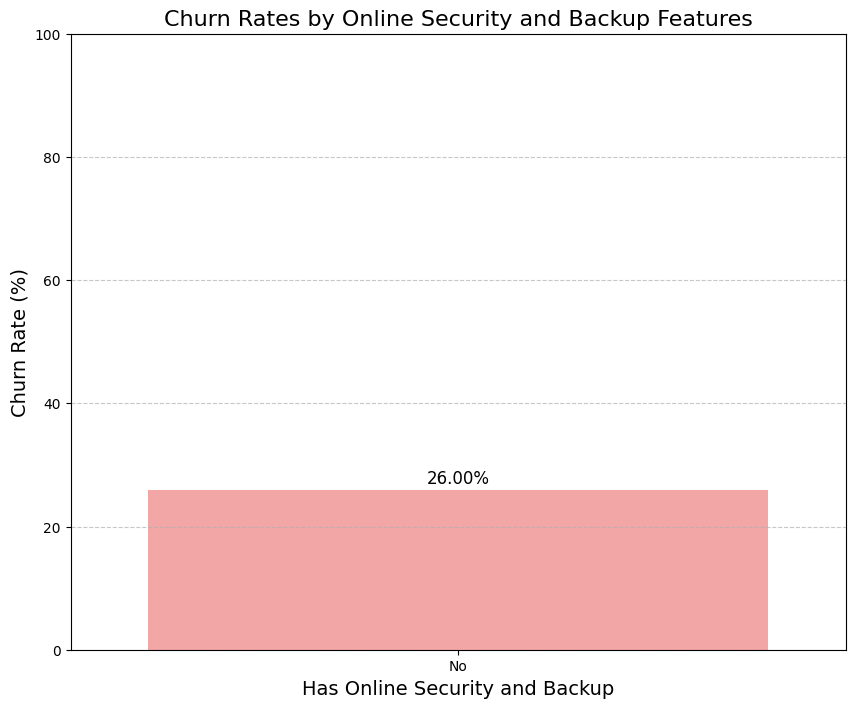

Chi-square test result: chi2=0.0, p-value=1.0


In [26]:
# Create a new column 'SecurityBackup' to indicate if a customer has both features
train_data['SecurityBackup'] = train_data.apply(lambda x: 'Yes' if x['OnlineSecurity'] == 'Yes' and x['OnlineBackup'] == 'Yes' else 'No', axis=1)

# Calculate churn rates
churn_rates = train_data.groupby('SecurityBackup')['Churn'].value_counts(normalize=True).unstack() * 100
churn_rates = churn_rates[True]  
print(churn_rates)

# Plot churn rates
plt.figure(figsize=(10, 8))
sns.barplot(x=churn_rates.index, y=churn_rates.values, palette=['#FF9999', '#66B2FF'])
plt.title('Churn Rates by Online Security and Backup Features', fontsize=16)
plt.xlabel('Has Online Security and Backup', fontsize=14)
plt.ylabel('Churn Rate (%)', fontsize=14)
plt.ylim(0, 100)

for i, v in enumerate(churn_rates.values):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Perform a chi-square test
contingency_table = pd.crosstab(train_data['SecurityBackup'], train_data['Churn'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test result: chi2={chi2}, p-value={p}")

Chi-square test result for OnlineSecurity: chi2=190.7824349065238, p-value=2.14557749710305e-43
Chi-square test result for OnlineBackup: chi2=95.32727848401908, p-value=1.6137410524000486e-22
Chi-square test result for DeviceProtection: chi2=82.39819413218379, p-value=1.1125540255690397e-19
Chi-square test result for TechSupport: chi2=226.753172215389, p-value=3.043988790814751e-51
Chi-square test result for StreamingTV: chi2=3.189766932412323, p-value=0.07410057574475713
Chi-square test result for StreamingMovies: chi2=0.7466708144833576, p-value=0.3875323219110569


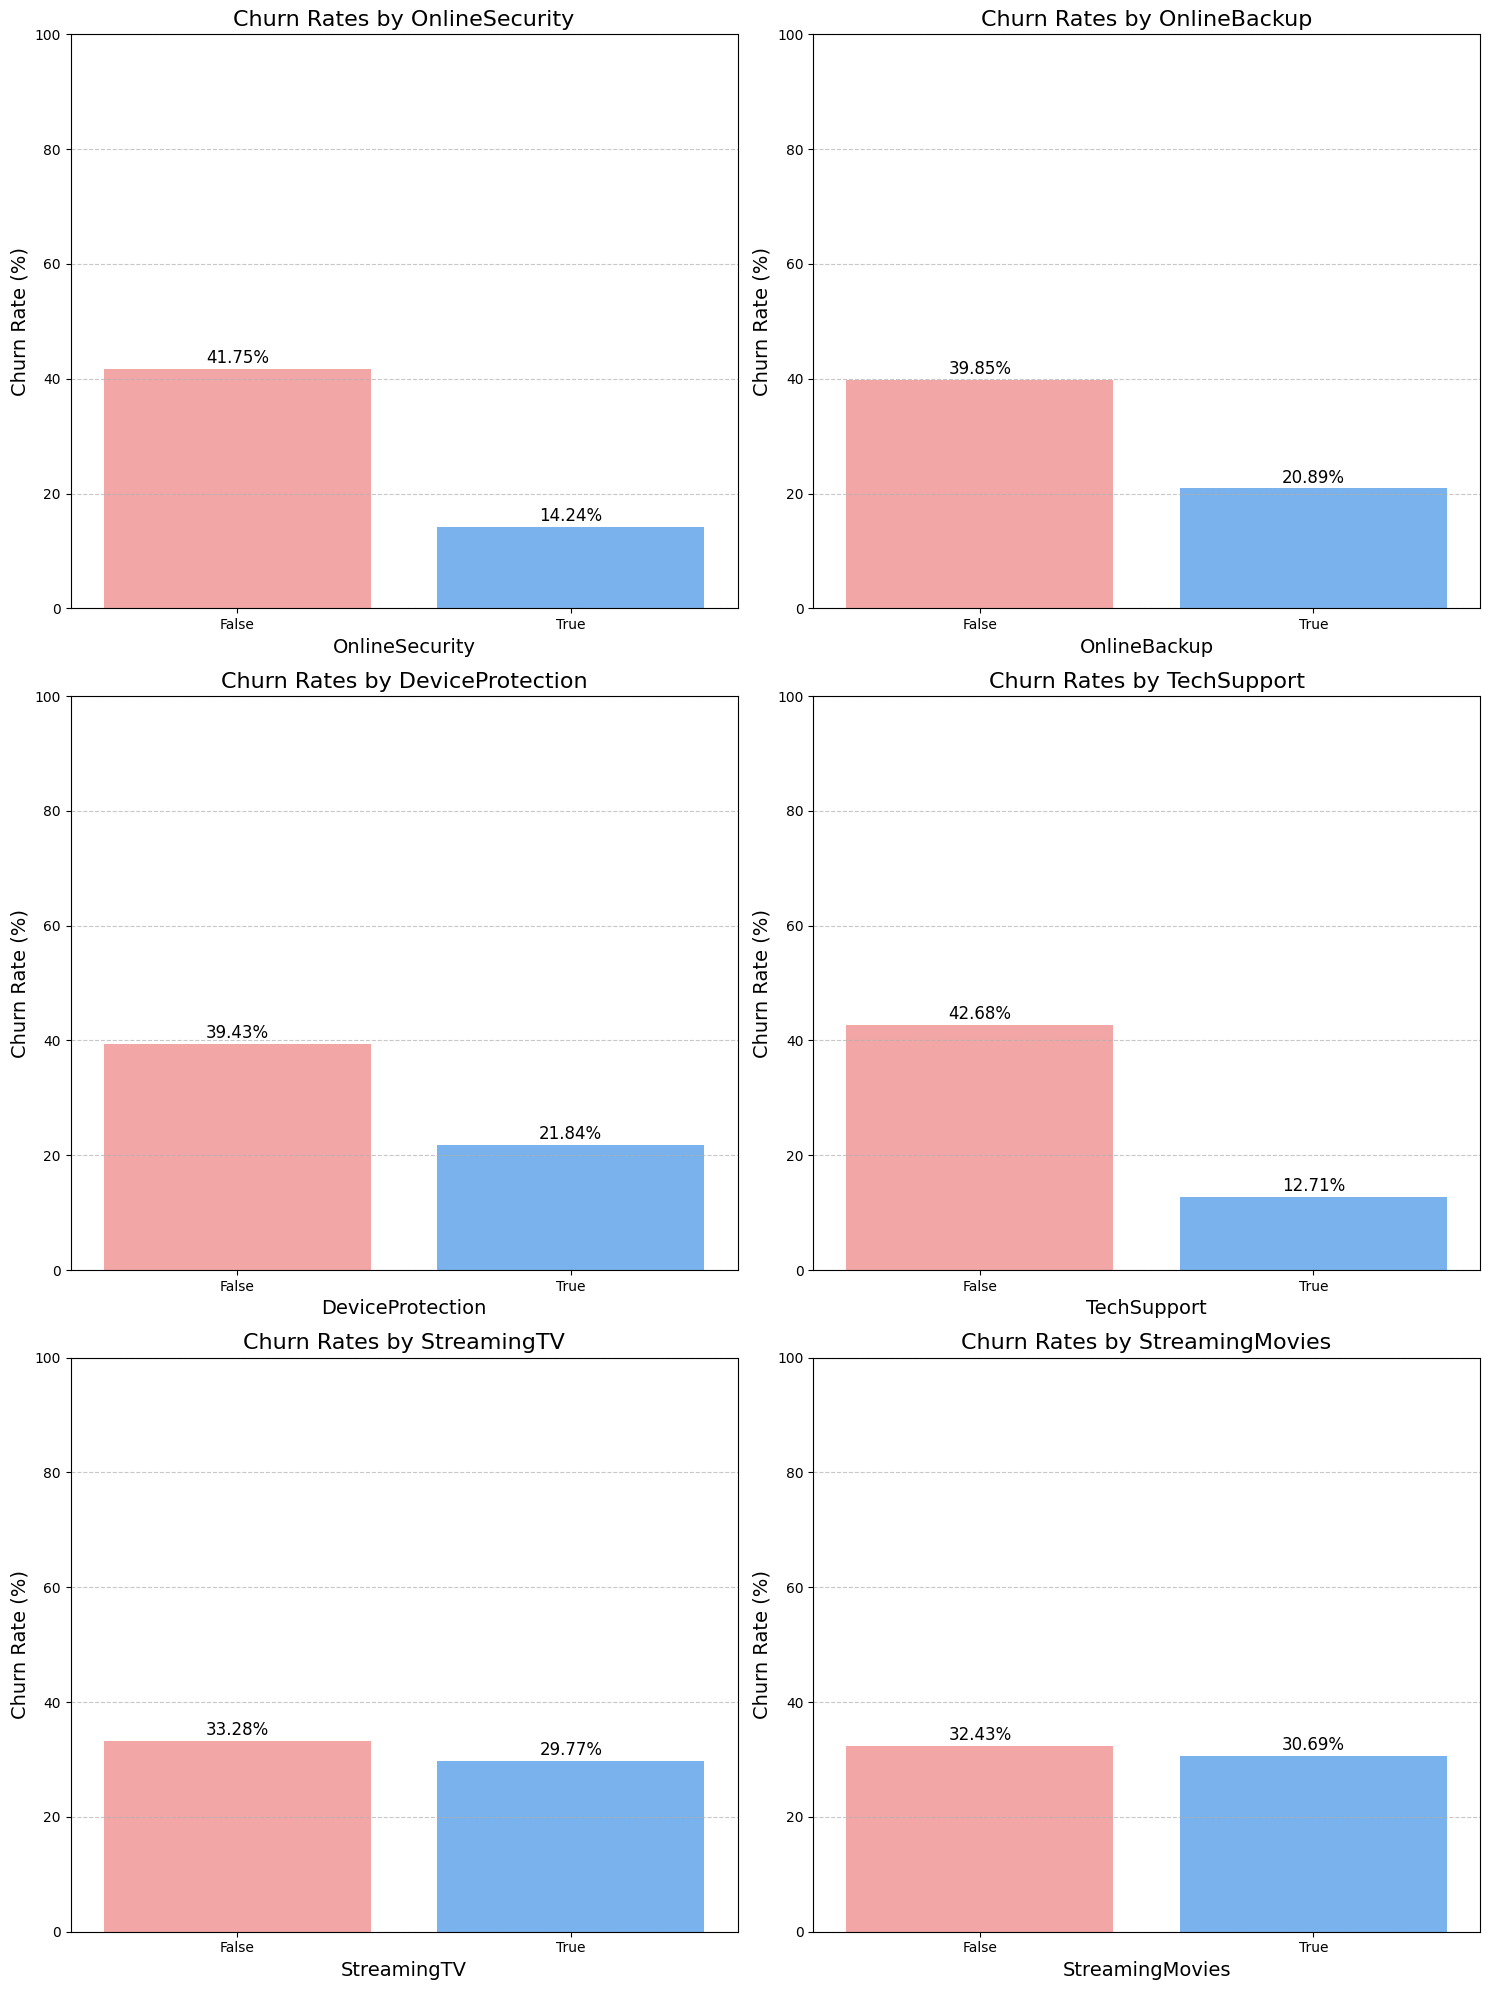

In [27]:
# Comprehensive Analysis for All Service Features

# List of service features to analyze
service_features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Initialize a figure for subplots
plt.figure(figsize=(15, 20))

# Loop through each service feature
for i, feature in enumerate(service_features, 1):
    # Calculate churn rates
    churn_rates = train_data.groupby(feature)['Churn'].value_counts(normalize=True).unstack() * 100
    churn_rates = churn_rates[True] 
    
    # Plot churn rates
    plt.subplot(3, 2, i)
    sns.barplot(x=churn_rates.index, y=churn_rates.values, palette=['#FF9999', '#66B2FF'])
    plt.title(f'Churn Rates by {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Churn Rate (%)', fontsize=14)
    plt.ylim(0, 100)
    
    for j, v in enumerate(churn_rates.values):
        plt.text(j, v + 1, f'{v:.2f}%', ha='center', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Perform a chi-square test
    contingency_table = pd.crosstab(train_data[feature], train_data['Churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test result for {feature}: chi2={chi2}, p-value={p}")

plt.tight_layout()
plt.show()

Key findings:

TechSupport, OnlineSecurity, OnlineBackup, and DeviceProtection have significant relationships with churn rates, in descending order of strength.

StreamingTV and StreamingMovies do not show significant relationships with churn rates.

Recommendations:

a. Focus on improving and promoting TechSupport, as it has the strongest relationship with reducing churn.

b. Emphasize the benefits of OnlineSecurity, OnlineBackup, and DeviceProtection to customers, as these features are associated with lower churn rates.

c. Consider bundling these significant features together to increase customer retention.

d. There are no significantly impact of StreamingTV and StreamingMovies on churn rates.

This analysis suggests that security and support-related features have a much stronger impact on customer retention than entertainment-related features.

3. Is there a correlation between monthly charges and churn, and what is the threshold beyond which the likelihood of churn increases significantly?

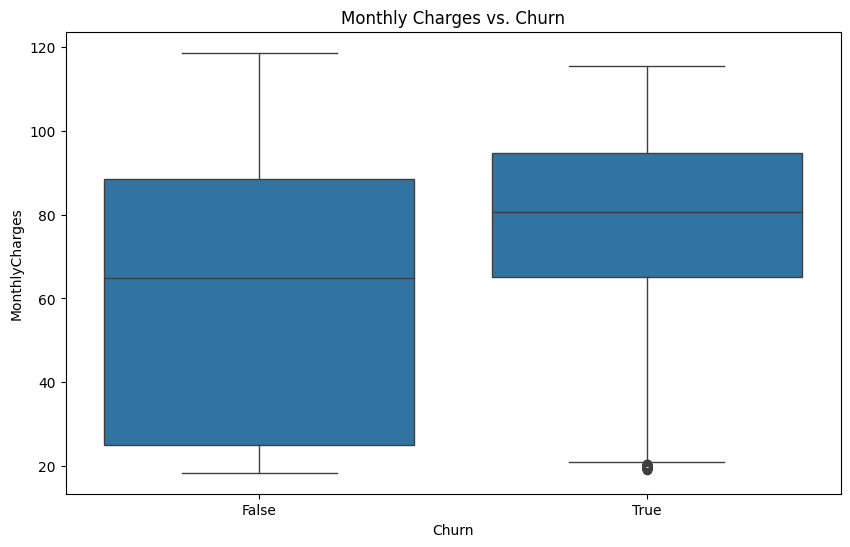

Correlation: 0.21188913672026716, p-value: 8.50377542809172e-32
ChargeBracket
(18.3, 38.45]     0.100396
(38.45, 58.5]     0.252475
(58.5, 78.55]     0.280000
(78.55, 98.6]     0.375921
(98.6, 118.65]    0.300000
Name: Churn, dtype: float64


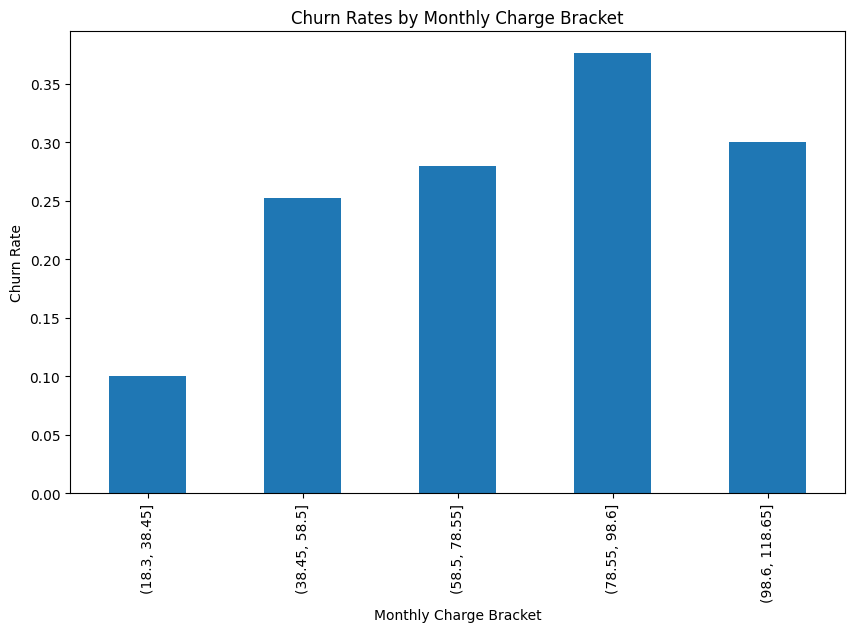

In [28]:

# Data Visualization
 
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=train_data)
plt.title('Monthly Charges vs. Churn')
plt.show()

# Statistical Analysis
# Point-biserial correlation
correlation, p_value = pointbiserialr(train_data['Churn'], train_data['MonthlyCharges'])
print(f"Correlation: {correlation}, p-value: {p_value}")

# Segmentation Analysis
train_data['ChargeBracket'] = pd.cut(train_data['MonthlyCharges'], bins=5)
churn_rates = train_data.groupby('ChargeBracket')['Churn'].mean()
print(churn_rates)

# Visualize churn rates by charge bracket
plt.figure(figsize=(10, 6))
churn_rates.plot(kind='bar')
plt.title('Churn Rates by Monthly Charge Bracket')
plt.xlabel('Monthly Charge Bracket')
plt.ylabel('Churn Rate')
plt.show()

The correlation coefficient of 0.21188913672026716 indicates a weak positive correlation between charges and churn rate. This means that as charges increase, there is a slight tendency for churn rate to increase as well, but the relationship is not strong.

The p-value of 8.50377542809172e-32 is extremely small (much less than 0.05), which suggests that this correlation is statistically significant. This means that despite the weak correlation, we can be confident that the relationship between charges and churn rate is not due to random chance.

Looking at the churn rates across charge brackets, we can observe a general trend of increasing churn rates as charges increase, with the highest churn rate (37.59%) in the second-highest charge bracket. However, there is a slight decrease in the highest charge bracket, which explains why the overall correlation is weak despite the apparent trend.

This data suggests that while higher charges are associated with higher churn rates, the relationship is not linear or strong. Other factors likely influence customer churn as well. The company may want to investigate why customers in the higher charge brackets are more likely to churn and consider strategies to retain these high-value customers.

**Additional Questions**

1. Do customers with multiple lines (MultipleLines = Yes) have a lower churn rate compared to those with a single line?


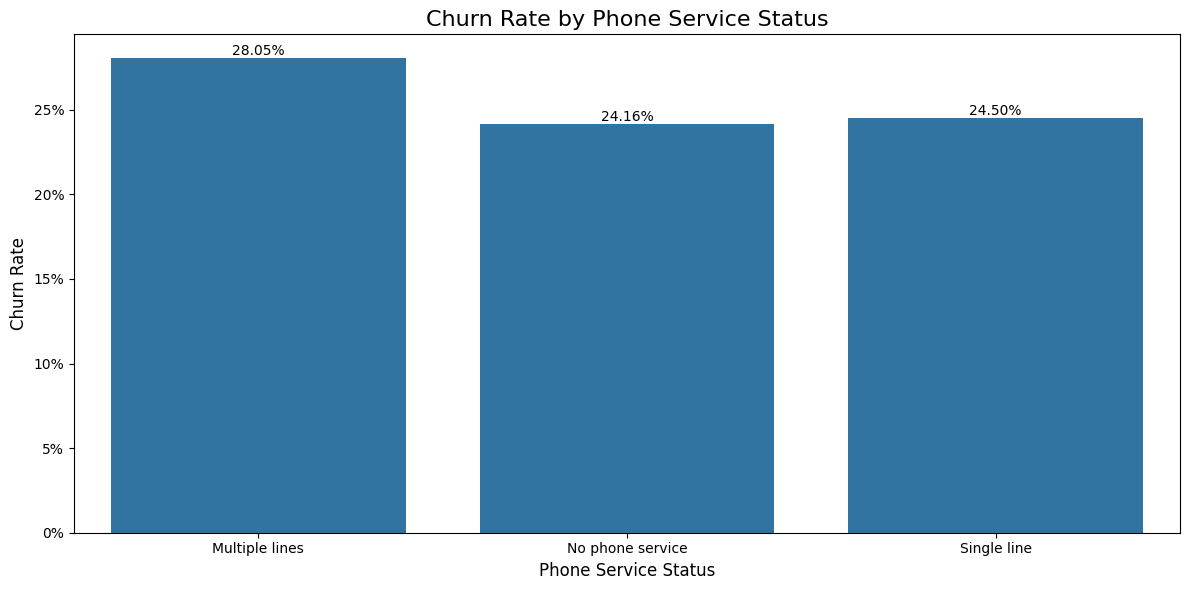

In [29]:

# Create a combined column that accurately represents the phone service status
def phone_status(row):
    if not row['PhoneService']:
        return 'No phone service'
    elif row['MultipleLines'] is None:
        return 'Single line'
    elif row['MultipleLines']:
        return 'Multiple lines'
    else:
        return 'Single line'

train_data['PhoneStatus'] = train_data.apply(phone_status, axis=1)

# Calculate churn rates for each category in PhoneStatus
churn_rates = train_data.groupby('PhoneStatus')['Churn'].apply(lambda x: (x == True).mean())

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=churn_rates.index, y=churn_rates.values)

# Customize the plot
plt.title('Churn Rate by Phone Service Status', fontsize=16)
plt.xlabel('Phone Service Status', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)

# Add value labels on top of each bar
for i, v in enumerate(churn_rates.values):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom')

# Adjust y-axis to show percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()



In [30]:
# Print the churn rates
print("Churn rates by Phone Service Status:")
print(churn_rates)

# Compare churn rates
no_service_churn = churn_rates.get('No phone service', 'N/A')
single_line_churn = churn_rates.get('Single line', 'N/A')
multiple_lines_churn = churn_rates.get('Multiple lines', 'N/A')

print(f"\nChurn rate for no phone service: {no_service_churn:.2%}" if isinstance(no_service_churn, float) else f"\nChurn rate for no phone service: {no_service_churn}")
print(f"Churn rate for single line: {single_line_churn:.2%}" if isinstance(single_line_churn, float) else f"Churn rate for single line: {single_line_churn}")
print(f"Churn rate for multiple lines: {multiple_lines_churn:.2%}" if isinstance(multiple_lines_churn, float) else f"Churn rate for multiple lines: {multiple_lines_churn}")

# Compare multiple lines to single line
if isinstance(multiple_lines_churn, float) and isinstance(single_line_churn, float):
    if multiple_lines_churn < single_line_churn:
        print("\nCustomers with multiple lines have a lower churn rate compared to those with a single line.")
    else:
        print("\nCustomers with multiple lines do not have a lower churn rate compared to those with a single line.")

# Find category with lowest churn rate
min_churn_category = churn_rates.idxmin()
min_churn_rate = churn_rates.min()
print(f"\nThe category with the lowest churn rate is '{min_churn_category}' with a rate of {min_churn_rate:.2%}")

Churn rates by Phone Service Status:
PhoneStatus
Multiple lines      0.280526
No phone service    0.241636
Single line         0.244955
Name: Churn, dtype: float64

Churn rate for no phone service: 24.16%
Churn rate for single line: 24.50%
Churn rate for multiple lines: 28.05%

Customers with multiple lines do not have a lower churn rate compared to those with a single line.

The category with the lowest churn rate is 'No phone service' with a rate of 24.16%


This analysis provides a clear understanding of how phone service status relates to churn. It highlights that customers with multiple lines are more likely to churn, while those with no phone service are the least likely to churn.

2. Is there a significant difference in churn rates between customers with different types of internet service (DSL, Fiber Optic, No)?


In [31]:
#Create a contingency table (cross-tabulation of InternetService and Churn to show count of customers who churned or didn't churn for each internet service type )

contingency_table = pd.crosstab(train_data['InternetService'], train_data['Churn'])
# print(f'{contingency_table}')

In [32]:
# Perform a chi-square test of independence to determine if there's a statistically significant relationship between the type of internet service and churn rates.

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test result for InternetService: chi2={chi2}, p-value={p}")

Chi-square test result for InternetService: chi2=366.549262754299, p-value=0.3875323219110569


In [33]:
# Calculate churn rates

churn_rates = train_data.groupby('InternetService')['Churn'].mean()
print(churn_rates)

InternetService
DSL            0.169980
Fiber optic    0.424423
No             0.059908
Name: Churn, dtype: float64


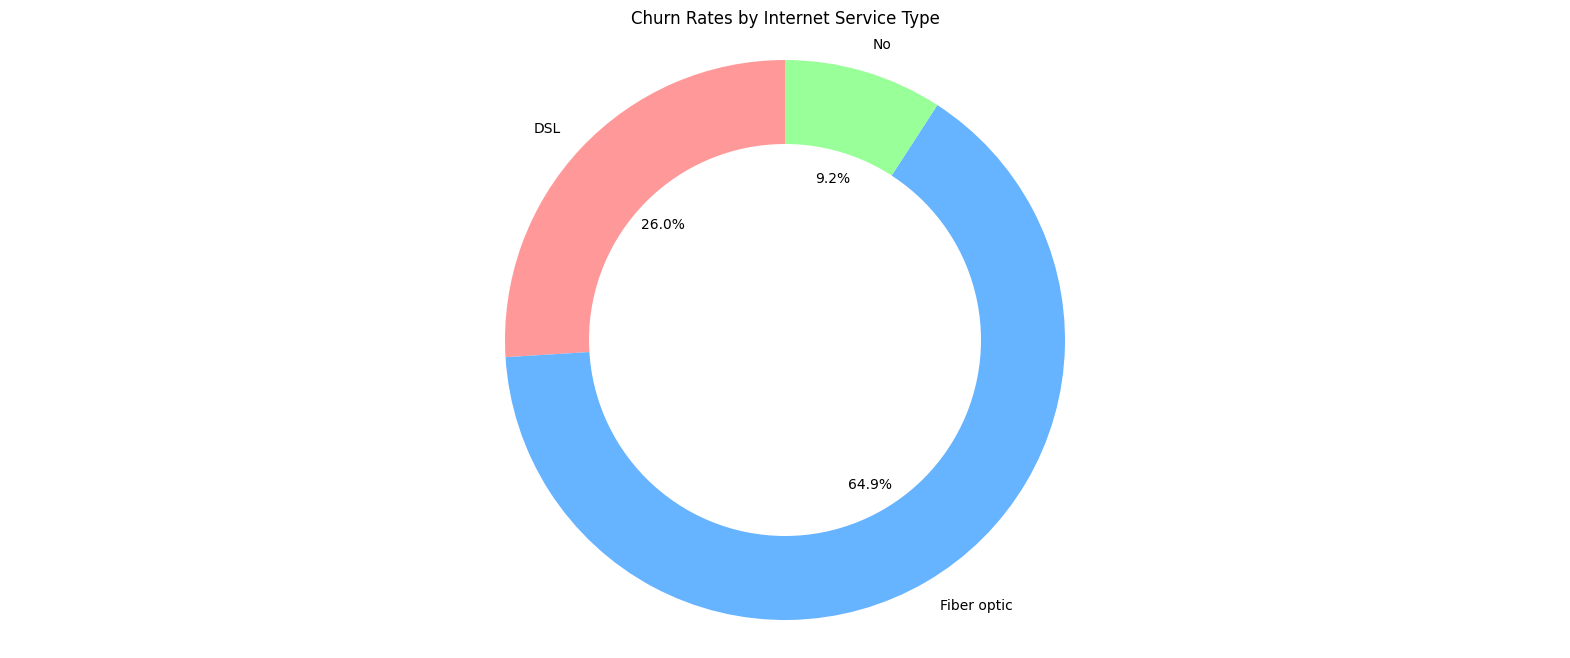

In [34]:
# Visualize the results


fig, ax = plt.subplots(figsize=(20, 8))
wedges, texts, autotexts = ax.pie(churn_rates, labels=churn_rates.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])

# Create a circle at the center to transform the pie chart to a donut chart
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig.gca().add_artist(center_circle)

plt.title('Churn Rates by Internet Service Type')
plt.axis('equal')
plt.show()

Interpretation:

Statistical Significance:

The p-value (0.3875) is much larger than the typical significance level of 0.05. There is not enough statistical evidence to conclude that there is a significant relationship between the type of internet service and churn rates.

Practical (Visual) Significance:

Despite the lack of statistical significance, there are notable differences in churn rates among the different internet service types:
Fiber optic has the highest churn rate at 42.44%, which is significantly higher than the other two categories.
DSL has a moderate churn rate of 17%.
Customers with no internet service have the lowest churn rate at about 6%.

While the statistical test does not show significance, the practical differences in churn rates are substantial and warrant attention from a business perspective. It is important to consider both statistical and practical significance when making business decisions.

3. Does the presence of dependents (Dependents = Yes) increase the likelihood of churn?


In [35]:
# Calculate churn rates
churn_rates_dependents = train_data.groupby('Dependents')['Churn'].mean()
print("Churn rates by Dependents:")
print(churn_rates_dependents)

Churn rates by Dependents:
Dependents
False    0.310628
True     0.147312
Name: Churn, dtype: float64


In [36]:
# Create a contingency table
contingency_table = pd.crosstab(train_data['Dependents'], train_data['Churn'])
# print("\nContingency Table:")
# #print(contingency_table)

In [37]:
# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square statistic: {chi2}")
print(f"P-value: {p_value}")


Chi-square statistic: 88.1112799065113
P-value: 6.187377909797934e-21


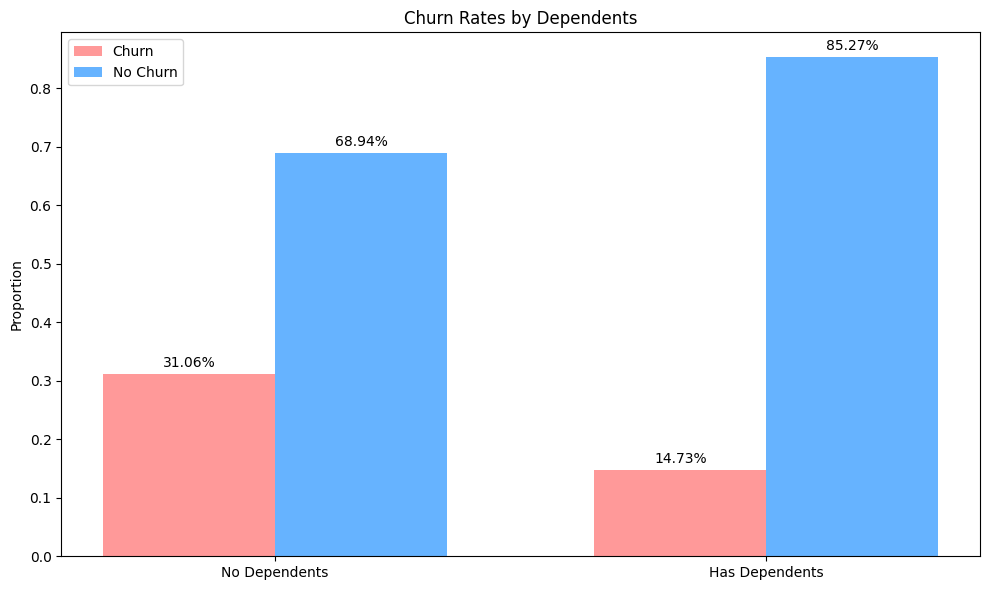

In [38]:
#Visualize the results

dependents = ['No Dependents', 'Has Dependents']
churn = churn_rates_dependents.values
no_churn = 1 - churn

x = np.arange(len(dependents))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, churn, width, label='Churn', color='#ff9999')
rects2 = ax.bar(x + width/2, no_churn, width, label='No Churn', color='#66b3ff')


ax.set_ylabel('Proportion')
ax.set_title('Churn Rates by Dependents')
ax.set_xticks(x)
ax.set_xticklabels(dependents)
ax.legend()

# Add value labels on the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

The presence of dependents significantly decreases the likelihood of churn, and this relationship is statistically significant. This information can be valuable for developing targeted retention strategies and service offerings.

4. Is there a correlation between the total charges (TotalCharges) and churn, and what is the threshold beyond which the likelihood of churn increases significantly?


In [39]:
# Calculate the correlation between TotalCharges and Churn

train_data['Churn'] = train_data['Churn'].map({False: 0, True: 1})

# Calculate the correlation
correlation = train_data['TotalCharges'].corr(train_data['Churn'])
print(f"Correlation between TotalCharges and Churn: {correlation}")

Correlation between TotalCharges and Churn: -0.19395638720233455


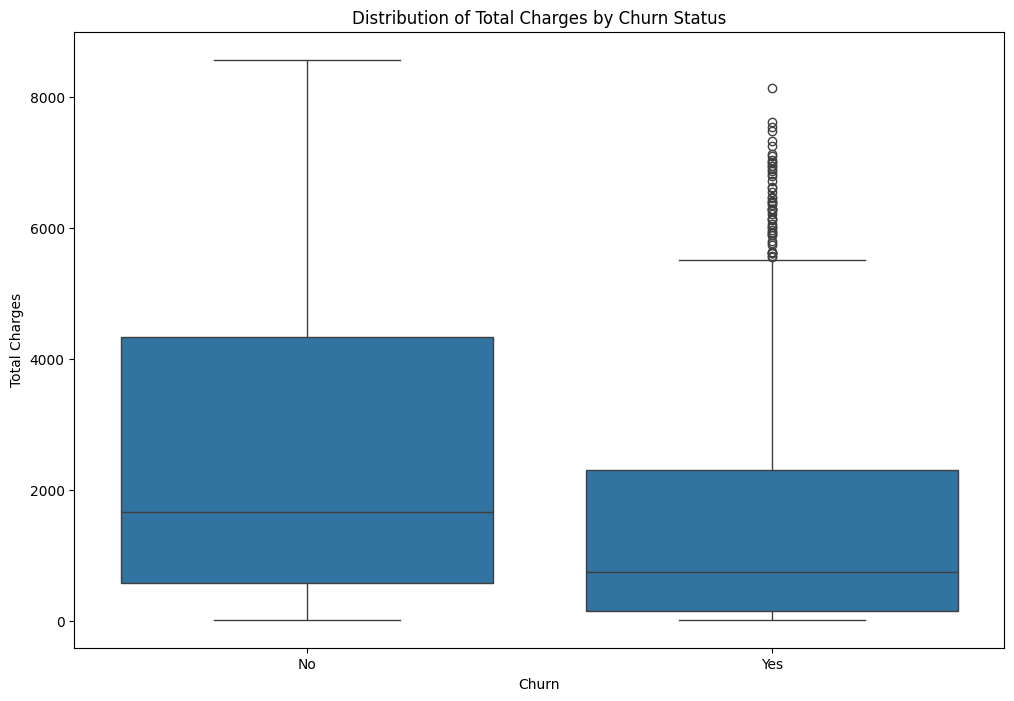

In [40]:
# Visualize the relationship between TotalCharges and Churn


plt.figure(figsize=(12, 8))
sns.boxplot(x='Churn', y='TotalCharges', data=train_data)
plt.title('Distribution of Total Charges by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.xticks([0, 1], ['No', 'Yes'])  # Set the x-axis labels to 'No' and 'Yes'
plt.show()

In [41]:
# Identify the threshold for TotalCharges beyond which churn increases significantly


# Prepare the data for logistic regression
X = train_data[['TotalCharges']]
y = train_data['Churn']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

# Calculate the predicted probabilities
train_data['Churn_Prob'] = logit_model.predict(X)

# Determine the threshold
threshold = np.percentile(train_data[train_data['Churn'] == 1]['TotalCharges'], 75)
print(f"Threshold for TotalCharges beyond which churn increases significantly: {threshold}")

Optimization terminated successfully.
         Current function value: 0.552305
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2998
Method:                           MLE   Df Model:                            1
Date:                Sat, 13 Jul 2024   Pseudo R-squ.:                 0.03621
Time:                        09:28:20   Log-Likelihood:                -1656.9
converged:                       True   LL-Null:                       -1719.2
Covariance Type:            nonrobust   LLR p-value:                 6.514e-29
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.5838      0.057    -10.176      0.000      -0.696      -0.471
TotalCharges    -0.0002

Interpretation:

Correlation:
The correlation between TotalCharges and Churn is -0.19395638720233455. This indicates a weak negative correlation, suggesting that as TotalCharges increase, the likelihood of churn slightly decreases.

Logistic Regression Results:
The coefficient for TotalCharges is -0.0002, which is statistically significant (p-value < 0.001).
This negative coefficient confirms the negative relationship between TotalCharges and churn probability.
For every unit increase in TotalCharges, the log-odds of churn decrease by 0.0002.

Model Fit:
The pseudo R-squared value is 0.03621, indicating that the model explains about 3.62% of the variance in churn.
The low R-squared suggests that while TotalCharges has a significant relationship with churn, it alone is not a strong predictor of churn.

Threshold:
The calculated threshold for TotalCharges beyond which churn increases significantly is 2296.03759765625. However, given the negative relationship, this threshold might not be meaningful in the way it was initially interpreted.

While there is a statistically significant relationship between TotalCharges and churn, it's not as straightforward as initially assumed. Higher TotalCharges are associated with slightly lower churn probability, but this factor alone is not a strong predictor of churn.

5. Do customers with paperless billing (PaperlessBilling = Yes) have a lower churn rate compared to those without paperless billing?

In [42]:
# Calculate churn rates for paperless and non-paperless billing customers

churn_rates = train_data.groupby('PaperlessBilling')['Churn'].mean()
print("Churn rates by PaperlessBilling:")
print(churn_rates)

Churn rates by PaperlessBilling:
PaperlessBilling
False    0.157680
True     0.330518
Name: Churn, dtype: float64


In [43]:
#Create a contingency table

contingency_table = pd.crosstab(train_data['PaperlessBilling'], train_data['Churn'])
# print("\nContingency Table:")
# print(contingency_table)

In [44]:
# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square statistic: {chi2}")
print(f"P-value: {p_value}")


Chi-square statistic: 111.61004601733936
P-value: 4.349779290795884e-26


In [45]:
# Calculate the overall churn rate

overall_churn_rate = train_data['Churn'].mean()
print(f"\nOverall churn rate: {overall_churn_rate:.4f}")


Overall churn rate: 0.2600


In [46]:
#Normalize the contingency table to get proportions

contingency_table_norm = contingency_table.div(contingency_table.sum(axis=1), axis=0)

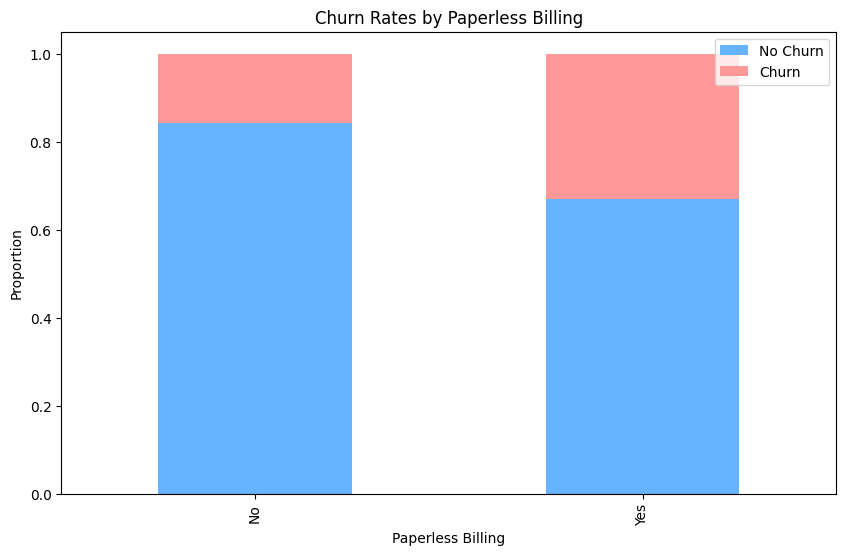

In [47]:
# Visualize the result  (stacked bar chart)

contingency_table_norm.plot(kind='bar', stacked=True, color=['#66b3ff', '#ff9999'], figsize=(10, 6))
plt.title('Churn Rates by Paperless Billing')
plt.xlabel('Paperless Billing')
plt.ylabel('Proportion')
plt.legend(['No Churn', 'Churn'], loc='upper right')
plt.xticks([0, 1], ['No', 'Yes'])  # Set the x-axis labels to 'No' and 'Yes'
plt.show()

Contrary to what might be expected, customers with paperless billing (PaperlessBilling = Yes) have a significantly higher churn rate compared to those without paperless billing. The relationship between paperless billing and churn is statistically significant, indicating that this is not due to random chance. Paperless billing appears to be a risk factor for churn as customers with paperless billing churn at a rate higher than the overall average.

6. Is there a significant difference in churn rates between customers with different payment methods (Electronic check, Mailed check, Bank transfer, Credit card)?

In [48]:
# Calculate churn rates for different payment methods

churn_rates = train_data.groupby('PaymentMethod')['Churn'].mean()
print("Churn rates by PaymentMethod:")
print(churn_rates)

Churn rates by PaymentMethod:
PaymentMethod
Bank transfer (automatic)    0.177584
Credit card (automatic)      0.138508
Electronic check             0.448207
Mailed check                 0.179448
Name: Churn, dtype: float64


In [49]:
# Create a contingency table

contingency_table = pd.crosstab(train_data['PaymentMethod'], train_data['Churn'])
# print("\nContingency Table:")
# print(contingency_table)

In [50]:
# Perform chi-square test

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square statistic: {chi2}")
print(f"P-value: {p_value}")


Chi-square statistic: 281.486999601212
P-value: 1.009435617846268e-60


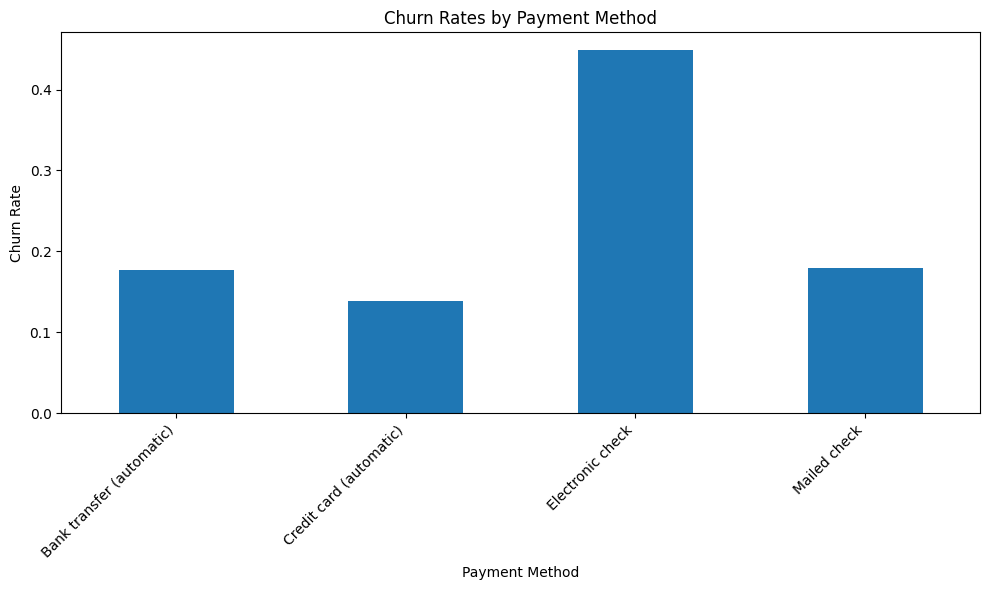

In [51]:
# Visualize the churn rates

plt.figure(figsize=(10, 6))
churn_rates.plot(kind='bar')
plt.title('Churn Rates by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The payment method is strongly associated with churn rates, with electronic check users being at the highest risk of churning. This insight should be used to inform customer retention strategies and to guide efforts in promoting more stable payment methods, particularly automatic credit card payments (bank transfers and credit card).

#### **<span style="color: skyblue;">Key Insights</span>**

1. **Number of rows:** 3000 entries (rows) in the dataset.
2. **Number of columns:** 21 columns (features) in the dataset.
3. **Column data types:**
    - Boolean (bool): 5 columns (SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling)
    - Integer (int64): 1 column (tenure)
    - Float: 2 columns (MonthlyCharges, TotalCharges)
    - Object (string): 13 columns (customerID, gender, MultipleLines, InternetService, etc.)
4. **Null values:** 
    - MultipleLines: 269 null values
    - OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies: 651 null values each (likely due to a missing value in a related feature)
    - TotalCharges: 5 null values
    - Churn: 1 null value
5. **Duplicated values:** 0 (No duplicated values)

5. **Data distribution:** The dataset (Numerical) is not evenly distributed, with obvious skewness in [Total charges (positive skewness), tenure (Heavy-Tailed), MonthlyCharges (Semi-Lognormal)]. However, the categorical counterpart seems to be evenly distributed.
6. **Unique Values:** These features have unique values (they contain a 'none' value)
    - MultipleLines
    - OnlineSecurity
    - OnlineBackup
    - DeviceProtection
    - TechSupport
    - StreamingTV
    - StreamingMovies
    - Churn
7. **Outliers:** There is need for scaling of the numerical features before used for training.
8. **Correlation:** There is strong linear relationship between Total Charges and tenure. However, Monthly Charges has mild positive relationship with Total Charges.

#### **<span style="color: red;">2. Evaluation Data</span>**

**Dataset Importation & Loading**

In [52]:
#Import CSV file

evaluation_data = pd.read_csv('../Data/LP2_Telco-churn-second-2000.csv')

evaluation_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


### **<span style="color: skyblue;">Exploratory Data Analysis</span>**

**Data Quality Assessment & Exploring data**

In [53]:
evaluation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [54]:
# Checking for the sum of null values

evaluation_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [55]:
# Checking for the sum of duplicated values

evaluation_data.duplicated().sum()

np.int64(0)

In [56]:
# Checking if the evaluation dataset (Numerical) is evenly distributed (Summary Statistics)

evaluation_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,2043.0,0.168380,0.374295,0.00,0.000,0.00,0.000,1.00
tenure,2043.0,32.649046,24.376248,0.00,9.000,30.00,55.000,72.00
MonthlyCharges,2043.0,64.712555,29.970010,18.55,35.825,70.25,89.625,118.35


In [57]:
# Summary Statistics for Categorical

evaluation_data.describe(include=['object', 'bool']).T

,count,unique,top,freq
customerID,2043,2043,3186-AJIEK,1
gender,2043,2,Male,1022
Partner,2043,2,No,1047
Dependents,2043,2,No,1412
PhoneService,2043,2,Yes,1823
MultipleLines,2043,3,No,987
InternetService,2043,3,Fiber optic,905
OnlineSecurity,2043,3,No,1029
OnlineBackup,2043,3,No,911
DeviceProtection,2043,3,No,923


In [58]:
# Checking the Columns for Unique values

columns = evaluation_data.columns

for column in columns:
    print (f'{column}')
    print (f'There are {evaluation_data[column].unique().size} unique values')
    print (f'There are {evaluation_data[column].unique()}')
    print ('=' * 50)

customerID
There are 2043 unique values
There are ['5600-PDUJF' '8292-TYSPY' '0567-XRHCU' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender
There are 2 unique values
There are ['Male' 'Female']
SeniorCitizen
There are 2 unique values
There are [0 1]
Partner
There are 2 unique values
There are ['No' 'Yes']
Dependents
There are 2 unique values
There are ['No' 'Yes']
tenure
There are 73 unique values
There are [ 6 19 69 11 64 39 15 25 66 61 43 12 23 71 34  5 41 72 14  1 10  7  9 48
 20 16  2 22 35 54 56 18 68 53 30 36 55 21 33 44  4 49 42 67 40 45 57  8
 65  3 17 28 52 47 50 46 29 27 13 24 62 26 60 51 70 59 38 37  0 58 31 32
 63]
PhoneService
There are 2 unique values
There are ['Yes' 'No']
MultipleLines
There are 3 unique values
There are ['No' 'No phone service' 'Yes']
InternetService
There are 3 unique values
There are ['DSL' 'Fiber optic' 'No']
OnlineSecurity
There are 3 unique values
There are ['No' 'Yes' 'No internet service']
OnlineBackup
There are 3 unique values
There are ['No'

#### **<span style="color: skyblue;">Univariate Analysis</span>**

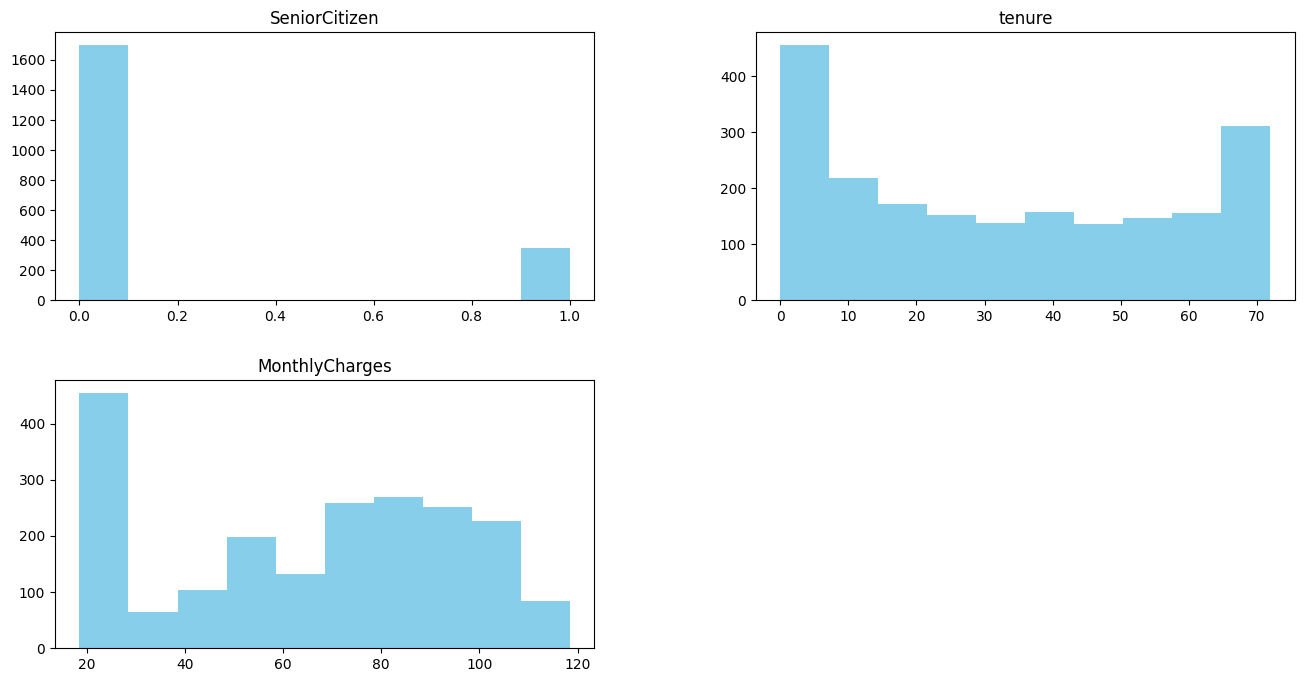

In [59]:
#Numerical Columns

evaluation_data.hist(figsize= (16,8), grid=False, color='skyblue')
plt.title ('Numerical Features Distributions')
plt.show()

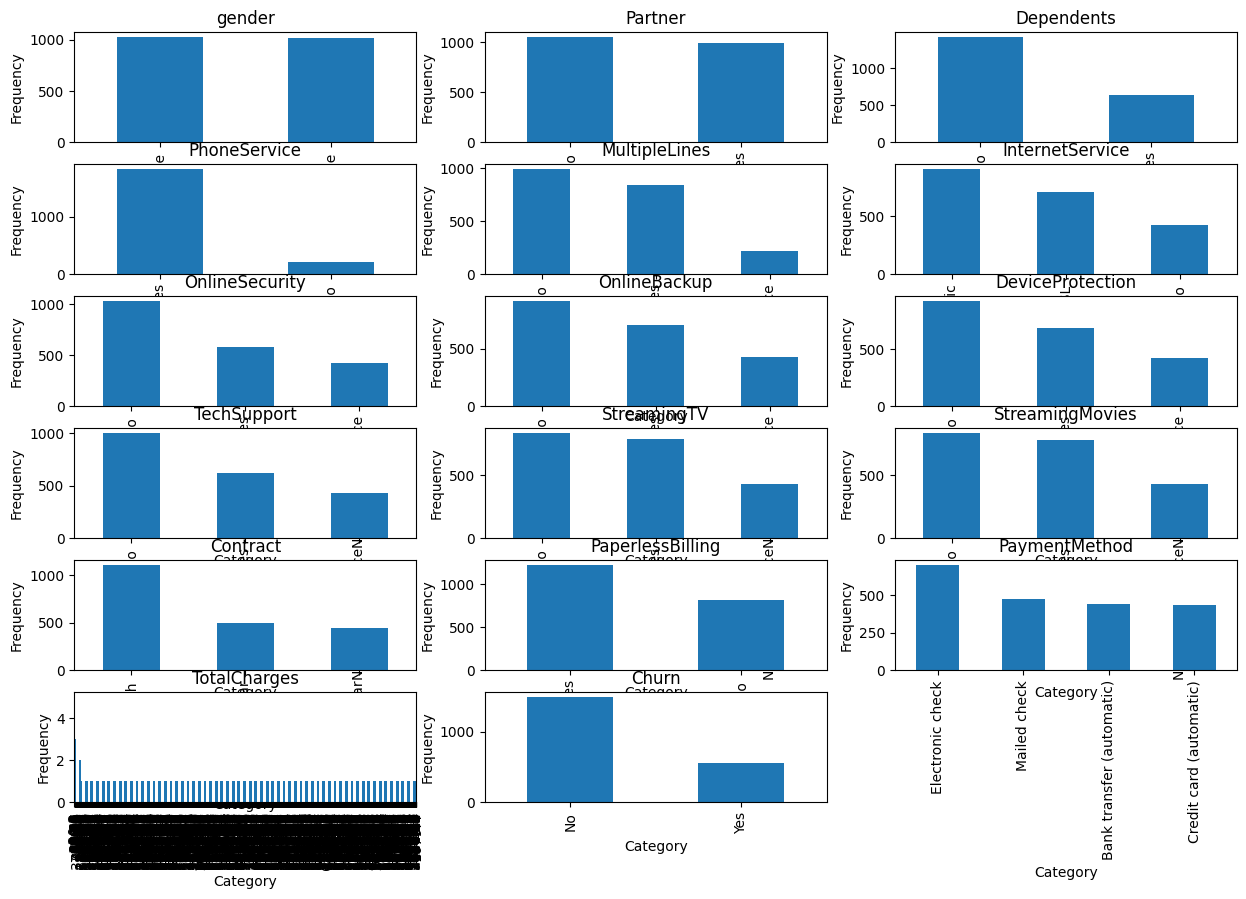

In [60]:
# Categorical Columns

# Define the figure size
plt.figure(figsize=(15, 10))

# Loop through each categorical variable
for i, var in enumerate(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']):
	# Create a subplot for each variable
	plt.subplot(6, 3, i+1)
	# Get the value counts
	counts = evaluation_data[var].value_counts()
	# Plot the bar chart
	counts.plot(kind='bar')
	# Set the title and labels
	plt.title(var)
	plt.xlabel('Category')
	plt.ylabel('Frequency')

# Layout and show the plot
plt.tight_layout()
plt.show()

#### **<span style="color: skyblue;">Key Insights</span>**

**1. Number of rows:** 2043 entries, indexed from 0 to 2042.

**2. Number of columns:** 21 columns, with various data types.

**3. Column data types:**
    - 2 integer columns (SeniorCitizen, tenure). 

    - 1 floating-point column (MonthlyCharges)
    
    - 18 object columns (strings or categorical values)
    
**4. Non-null count:** All columns have 2043 non-null values, indicating no missing data.

**Note:** Their are differences in data types for some features compared to that of Training Data. They are as follows:

    - TotalCharges: Training data (Float), Evaluation data (Object)
    
    - SeniorCitizens: Training data (Bool), Evaluation data (Integer)

**5. Duplicated values:** 0 (No duplicated values)

**6. Unique Value:** No "None" unique value. However, these features listed below have a "no online/phone service" as to "none" when compared to the training data:

    - MultipleLines
    - OnlineSecurity
    - OnlineBackup
    - DeviceProtection
    - TechSupport
    - StreamingTV
    - StreamingMovies
    
**7. Data distribution:** The dataset (Numerical) is not evenly distributed


**Evaluation Data Handling**

In [61]:
# Convert data types in evaluate_data

evaluation_data['SeniorCitizen'] = evaluation_data['SeniorCitizen'].astype(bool)
evaluation_data['Partner'] = evaluation_data['Partner'].map({'Yes': True, 'No': False})
evaluation_data['Dependents'] = evaluation_data['Dependents'].map({'Yes': True, 'No': False})
evaluation_data['PhoneService'] = evaluation_data['PhoneService'].map({'Yes': True, 'No': False})
evaluation_data['PaperlessBilling'] = evaluation_data['PaperlessBilling'].map({'Yes': True, 'No': False})
evaluation_data['TotalCharges'] = pd.to_numeric(evaluation_data['TotalCharges'], errors='coerce')

In [62]:
def convert_multiple_lines(value):
    if value == 'No phone service':
        return None
    elif value == 'No':
        return False
    elif value == 'Yes':
        return True

evaluation_data['MultipleLines'] = evaluation_data['MultipleLines'].apply(convert_multiple_lines)
# test_data['MultipleLines'] = test_data['MultipleLines'].apply(convert_multiple_lines)

In [63]:
def convert_service(value):
    if value == 'No internet service':
        return None
    elif value == 'No':
        return False
    elif value == 'Yes':
        return True

service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for column in service_columns:
    evaluation_data[column] = evaluation_data[column].apply(convert_service)
    # test_data[column] = test_data[column].apply(convert_service)

In [64]:
# Convert 'Churn' column
def convert_churn(value):
    if value == 'No':
        return False
    elif value == 'Yes':
        return True
    else:
        return None

evaluation_data['Churn'] = evaluation_data['Churn'].apply(convert_churn)



#### **<span style="color: red;">3. Testing Data</span>**

**Dataset Importation & Loading**

In [65]:
#Import Excel file

test_data = pd.read_excel('../Data/Telco-churn-last-2000.xlsx')

test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


### **<span style="color: skyblue;">Exploratory Data Analysis</span>**

**Data Quality Assessment & Exploring data**

In [66]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [67]:
# Checking for the sum of null values

test_data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [68]:
# Checking for the sum of duplicated values

test_data.duplicated().sum()

np.int64(0)

In [69]:
# Checking if the test dataset (Numerical) is evenly distributed (Summary Statistics)

test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,2000.0,0.161500,0.368084,0.00,0.00,0.0,0.000,1.00
tenure,2000.0,31.853000,24.632677,0.00,8.00,27.0,55.000,72.00
MonthlyCharges,2000.0,63.933325,30.136858,18.25,34.25,69.8,89.275,118.75


In [70]:
# Summary Statistics for Categorical

test_data.describe(include=['object', 'bool']).T

,count,unique,top,freq
customerID,2000,2000,1862-SKORY,1
gender,2000,2,Female,1004
Partner,2000,2,No,1056
Dependents,2000,2,No,1451
PhoneService,2000,2,Yes,1807
MultipleLines,2000,3,No,966
InternetService,2000,3,Fiber optic,848
OnlineSecurity,2000,3,No,991
OnlineBackup,2000,3,No,857
DeviceProtection,2000,3,No,876


In [71]:
# Checking the Columns for Unique values

columns = test_data.columns

for column in columns:
    print (f'{column}')
    print (f'There are {test_data[column].unique().size} unique values')
    print (f'There are {test_data[column].unique()}')
    print ('=' * 50)

customerID
There are 2000 unique values
There are ['7613-LLQFO' '4568-TTZRT' '9513-DXHDA' ... '4816-JBHOV' '8920-NAVAY'
 '1699-TLDLZ']
gender
There are 2 unique values
There are ['Male' 'Female']
SeniorCitizen
There are 2 unique values
There are [0 1]
Partner
There are 2 unique values
There are ['No' 'Yes']
Dependents
There are 2 unique values
There are ['No' 'Yes']
tenure
There are 73 unique values
There are [12  9 27  1 24 14 32 11 38 54 29 44 59  3 18 67 22 33  5  2 72 16  8 23
 50 17 68 25 71 46 48 61 37 65 49 64 21 10  6 51 47 52 35 45  4 60 28 39
 30 55 58 26 43 56 36 13 70 69 41 15 19 31 34 66 40  7 53 63 42  0 57 62
 20]
PhoneService
There are 2 unique values
There are ['Yes' 'No']
MultipleLines
There are 3 unique values
There are ['Yes' 'No' 'No phone service']
InternetService
There are 3 unique values
There are ['Fiber optic' 'No' 'DSL']
OnlineSecurity
There are 3 unique values
There are ['No' 'No internet service' 'Yes']
OnlineBackup
There are 3 unique values
There are ['No'

#### **<span style="color: skyblue;">Univariate Analysis</span>**

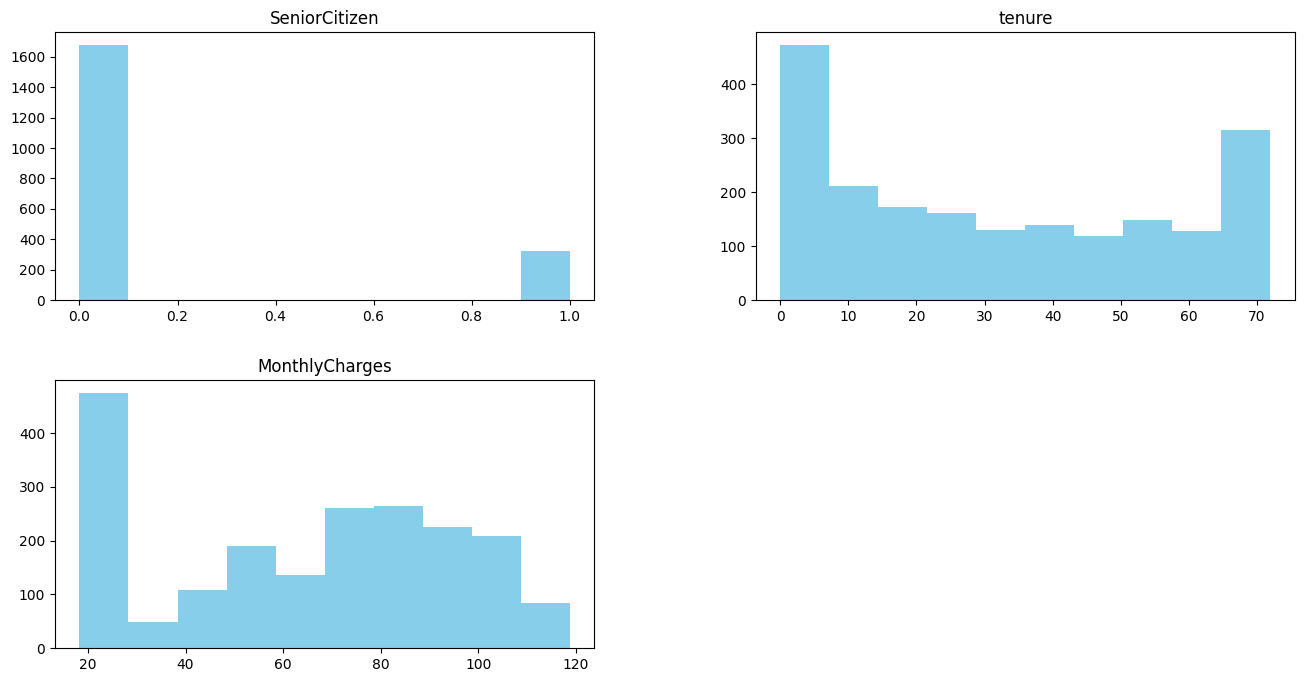

In [72]:
#Numerical Columns

test_data.hist(figsize= (16,8), grid=False, color='skyblue')
plt.title ('Numerical Features Distributions')
plt.show()

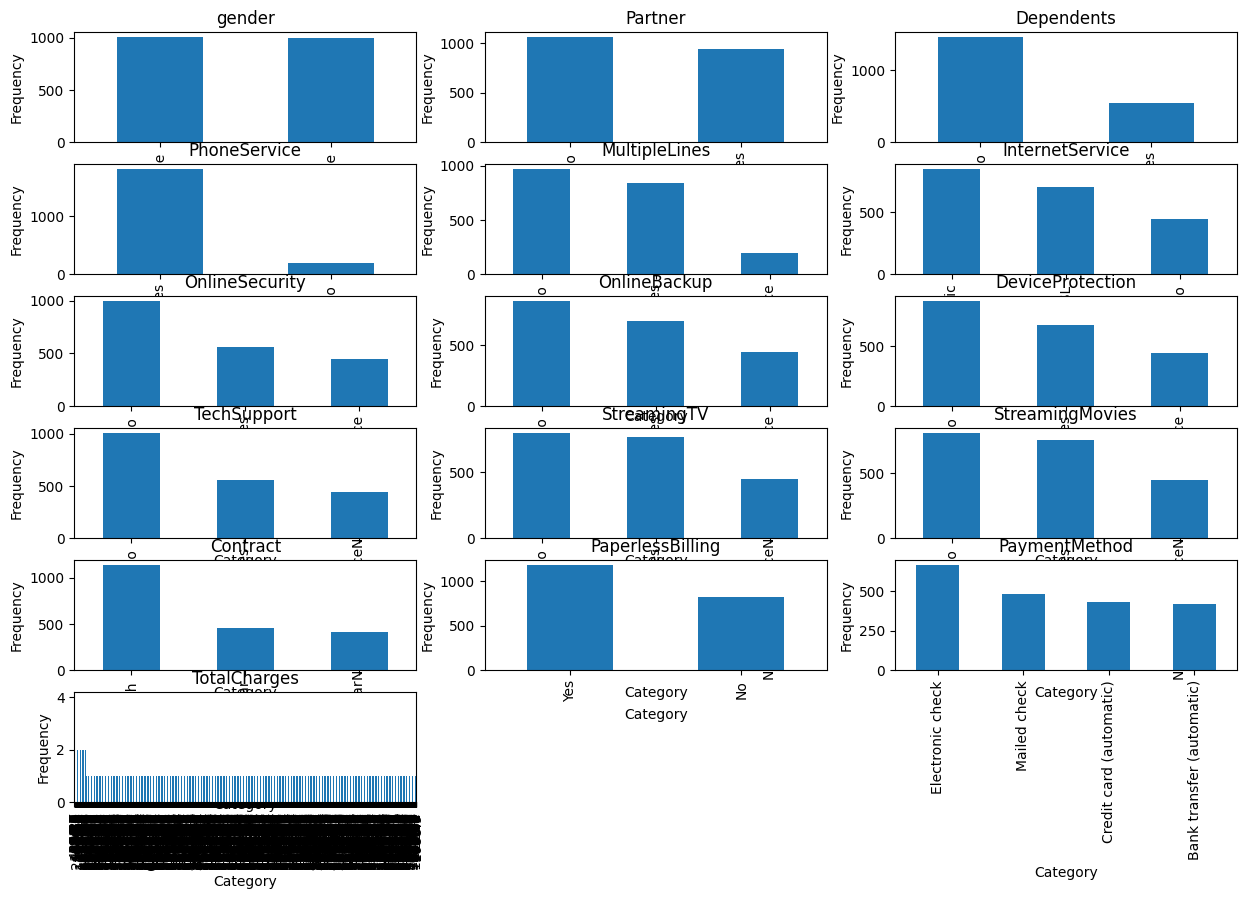

In [73]:
# Categorical Columns

# Define the figure size
plt.figure(figsize=(15, 10))

# Loop through each categorical variable
for i, var in enumerate(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']):
	# Create a subplot for each variable
	plt.subplot(6, 3, i+1)
	# Get the value counts
	counts = test_data[var].value_counts()
	# Plot the bar chart
	counts.plot(kind='bar')
	# Set the title and labels
	plt.title(var)
	plt.xlabel('Category')
	plt.ylabel('Frequency')

# Layout and show the plot
plt.tight_layout()
plt.show()

#### **<span style="color: skyblue;">Key Insights</span>**

**1. Number of records:** 2000 entries, indexed from 0 to 1999.

**2. Number of columns:** 20 columns, with various data types. No 'Churn' column

**3. Data types:**
    - 2 integer columns (SeniorCitizen, tenure)
    - 1 floating-point column (MonthlyCharges)
    - 17 object columns (strings or categorical values)

**4. No missing values:** All columns have 2000 non-null values, indicating a complete dataset.

**5. Column distribution:**
    - 2 columns with numerical data (SeniorCitizen, tenure, MonthlyCharges)
    - 17 columns with categorical data (objects)

**6. Duplicated values:** 0 (No duplicated values)

**7. Unique Value:** No "None" unique value. However, these features listed below have a "no online/phone service" as to "none" when compared to the training data:

    - MultipleLines
    - OnlineSecurity
    - OnlineBackup
    - DeviceProtection
    - TechSupport
    - StreamingTV
    - StreamingMovies
    
**8. Data distribution:** The dataset (Numerical) is not evenly distributed

**Handling the Test Dataset**

In [74]:
# Convert data types in test_data

test_data['SeniorCitizen'] = test_data['SeniorCitizen'].astype(bool)
test_data['Partner'] = test_data['Partner'].map({'Yes': True, 'No': False})
test_data['Dependents'] = test_data['Dependents'].map({'Yes': True, 'No': False})
test_data['PhoneService'] = test_data['PhoneService'].map({'Yes': True, 'No': False})
test_data['PaperlessBilling'] = test_data['PaperlessBilling'].map({'Yes': True, 'No': False})




In [75]:
test_data['TotalCharges'] = test_data['TotalCharges'].replace(' ', 0)
test_data['TotalCharges'] = pd.to_numeric(test_data['TotalCharges'])


In [76]:
def convert_multiple_lines(value):
    if value == 'No phone service':
        return None
    elif value == 'No':
        return False
    elif value == 'Yes':
        return True

test_data['MultipleLines'] = test_data['MultipleLines'].apply(convert_multiple_lines)

In [77]:
def convert_service(value):
    if value == 'No internet service':
        return None
    elif value == 'No':
        return False
    elif value == 'Yes':
        return True

service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']


for column in service_columns:
     test_data[column] = test_data[column].apply(convert_service)

In [78]:
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,False,False,False,12,True,True,Fiber optic,False,False,False,False,True,False,Month-to-month,True,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,False,False,False,9,True,False,No,None,None,None,None,None,None,Month-to-month,False,Mailed check,20.40,181.80
2,9513-DXHDA,Male,False,False,False,27,True,False,DSL,True,False,True,True,True,True,One year,False,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,False,False,True,27,True,True,Fiber optic,False,False,False,True,False,False,Month-to-month,True,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,False,True,True,1,True,False,Fiber optic,False,False,False,False,True,True,Month-to-month,False,Mailed check,89.15,89.15


In [79]:
test_data.dtypes

customerID           object
gender               object
SeniorCitizen          bool
Partner                bool
Dependents             bool
tenure                int64
PhoneService           bool
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling       bool
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

#### **<span style="color: skyblue;">Modelling</span>**

In [80]:
# Feature Columns

numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_columns = ['gender', 'MultipleLines', 'InternetService', 
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 
                       'Contract', 'PaymentMethod']
binary_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [81]:
# Convert boolean columns to int
for col in binary_columns:
    if train_data[col].dtype == bool:
        train_data[col] = train_data[col].astype(int)

In [82]:
# Combine numerical and binary columns

numeric_columns = numerical_columns + binary_columns

In [83]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', RobustScaler()),
            ('power-transformation', PowerTransformer(method='yeo-johnson'))
        ]), numeric_columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent', fill_value='Missing')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ]), categorical_columns)
    ])

In [84]:

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Decision Tree Pipeline
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Logistic Regression Pipeline
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# SVC Pipeline
svc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, probability=True))
])



In [85]:
# Prepare the features and target
X_train = train_data[numeric_columns + categorical_columns]
y_train = train_data['Churn']


In [86]:
# Encode the target variable


le = LabelEncoder()
y_train = le.fit_transform(y_train)


In [87]:
# Run cross-validation

models = {
    'Random Forest': rf_pipeline,
    'Decision Tree': dt_pipeline,
    'Logistic Regression': lr_pipeline,
    'SVC': svc_pipeline
   
}



for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} - Mean accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")



Random Forest - Mean accuracy: 0.803 (+/- 0.022)
Decision Tree - Mean accuracy: 0.731 (+/- 0.011)
Logistic Regression - Mean accuracy: 0.809 (+/- 0.024)
SVC - Mean accuracy: 0.812 (+/- 0.018)


In [88]:
# Fit the different pipelines  on the full training data

for name, model in models.items():
    model.fit(X_train, y_train)



#### **<span style="color: skyblue;">Model Evaluation</span>**

In [89]:
# Convert boolean columns to int
for col in binary_columns:
    if train_data[col].dtype == bool:
        evaluation_data[col] = evaluation_data[col].astype(int)

In [90]:
# Prepare evaluation
X_eval = evaluation_data[numeric_columns + categorical_columns]
y_eval = le.transform(evaluation_data['Churn'])

In [91]:
# Classification Report

report = []

for name, model in models.items():
    y_eval_pred = model.predict(X_eval)
    
    unbalanced_metrics = classification_report(y_eval, y_eval_pred, output_dict=True)

    accuracy = unbalanced_metrics['accuracy']
    precision = unbalanced_metrics['weighted avg']['precision']
    recall = unbalanced_metrics['weighted avg']['recall']
    f1 = unbalanced_metrics['weighted avg']['f1-score']

    report.append([name, accuracy, precision, recall, f1])


unbalanced_table = pd.DataFrame(report, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score'])

unbalanced_table = unbalanced_table.sort_values('F1_Score', ascending=False)

unbalanced_table.set_index('Model', inplace=True)


print(unbalanced_table.to_string(float_format='{:.6f}'.format))

                     Accuracy  Precision   Recall  F1_Score
Model                                                      
Logistic Regression  0.800783   0.791037 0.800783  0.792515
Random Forest        0.784630   0.773440 0.784630  0.775957
SVC                  0.789036   0.775875 0.789036  0.775197
Decision Tree        0.738620   0.739507 0.738620  0.739057


This table clearly presents the performance metrics for each model. Here is a brief interpretation of the results:

1. Logistic Regression performs best, with the highest F1-Score  and consistent high scores across all metrics.

2.  Random Forest comes in second, with slightly lower but still good performance.

3. SVC (Support Vector Classifier) is close behind Random Forest, showing similar performance levels.

4. Decision Tree has the lowest performance among these models for this particular dataset and problem.

**Balancing the Data**

In [92]:
# Random Forest Pipeline
rf_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    # # ('under-sampler', RandomUnderSampler(random_state=42)),
    ('over-sampler', SMOTE(random_state=42)),
    ('feature_selection', SelectKBest(mutual_info_classif, k='all')),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Decision Tree Pipeline
dt_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    # #('under-sampler', RandomUnderSampler(random_state=42)),
    ('over-sampler', SMOTE(random_state=42)),
    ('feature_selection', SelectKBest(mutual_info_classif, k= 'all')),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Logistic Regression Pipeline
lr_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    #('under-sampler', RandomUnderSampler(random_state=42)),
    ('over-sampler', SMOTE(random_state=42)),
    ('feature_selection', SelectKBest(mutual_info_classif, k='all')),
    ('classifier', LogisticRegression(random_state=42))
])

# SVC Pipeline
svc_pipeline = imbPipeline([
    ('preprocessor', preprocessor),
    # #('under-sampler', RandomUnderSampler(random_state=42)),
    ('over-sampler', SMOTE(random_state=42)),
    ('feature_selection', SelectKBest(mutual_info_classif, k='all')),
    ('classifier', SVC(random_state=42, probability=True))
])

In [93]:
# Run cross-validation

models = {
    'Random Forest': rf_pipeline,
    'Decision Tree': dt_pipeline,
    'Logistic Regression': lr_pipeline,
    'SVC': svc_pipeline
   
}



for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
    print(f"{name} - Mean F1 score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")


Random Forest - Mean F1 score: 0.794 (+/- 0.027)
Decision Tree - Mean F1 score: 0.746 (+/- 0.025)
Logistic Regression - Mean F1 score: 0.782 (+/- 0.035)
SVC - Mean F1 score: 0.784 (+/- 0.046)


In [94]:

# Create an empty list to store the results
results = []

for name, model in models.items():
    # Fit the pipeline on the training data
    model.fit(X_train, y_train)
    
    # Predict on the evaluation set
    y_eval_pred = model.predict(X_eval)
    
    # Calculate metrics
    balanced_metrics = classification_report(y_eval, y_eval_pred, output_dict=True)

    accuracy = balanced_metrics['accuracy']
    precision = balanced_metrics['weighted avg']['precision']
    recall = balanced_metrics['weighted avg']['recall']
    f1 = balanced_metrics['weighted avg']['f1-score']

    results.append([name, accuracy, precision, recall, f1])

# Create the DataFrame after the loop
balanced_table = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score'])

# Sort the DataFrame by 'F1_Score' in descending order
balanced_table = balanced_table.sort_values('F1_Score', ascending=False)

# Set the 'Model' column as the index
balanced_table.set_index('Model', inplace=True)

# Print the table
print(balanced_table.to_string(float_format='{:.6f}'.format))

                     Accuracy  Precision   Recall  F1_Score
Model                                                      
Random Forest        0.776309   0.772821 0.776309  0.774395
SVC                  0.753304   0.776850 0.753304  0.761251
Logistic Regression  0.750367   0.786188 0.750367  0.760649
Decision Tree        0.730788   0.737673 0.730788  0.733890


Observations:

1. Random Forest had the highest f1-score for balanced data and showed the most consistent performance across all three approaches after Logistic Regression.

2.  SVC performs well on unbalanced data and maintains relatively consistent performance across sampling methods.

3. Logistic Regression's performance was not as great as it was with the unbalanced data

4. Decision Tree consistently shows the lowest performance across all approaches.

In [95]:
rf_pipeline = models['Random Forest']

rf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('power-transformation',
                                                                   PowerTransformer())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImpute...
                                                  ['gender', 'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('over-sampler', SMOTE(random_state=42)),
                ('feature_selection',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x000001B792CAE4D0>)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [96]:
feature_columns = rf_pipeline.named_steps['preprocessor'].get_feature_names_out ()
feature_columns = np.array([col.split ('_')[-1] for col in feature_columns])
feature_columns

array(['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
       'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
       'Male', 'True', 'None', 'Fiber optic', 'No', 'True', 'None',
       'True', 'None', 'True', 'None', 'True', 'None', 'True', 'None',
       'True', 'None', 'One year', 'Two year', 'Credit card (automatic)',
       'Electronic check', 'Mailed check'], dtype='<U23')

In [97]:
importances = rf_pipeline.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importances': importances
})

importance_df





,Feature,Importances
0,tenure,0.143480
1,MonthlyCharges,0.119029
2,TotalCharges,0.120791
3,SeniorCitizen,0.015932
4,Partner,0.019040
5,Dependents,0.015954
6,PhoneService,0.003739
7,PaperlessBilling,0.020958
8,Male,0.030643
9,True,0.018331


**Visualize ROC Curve**

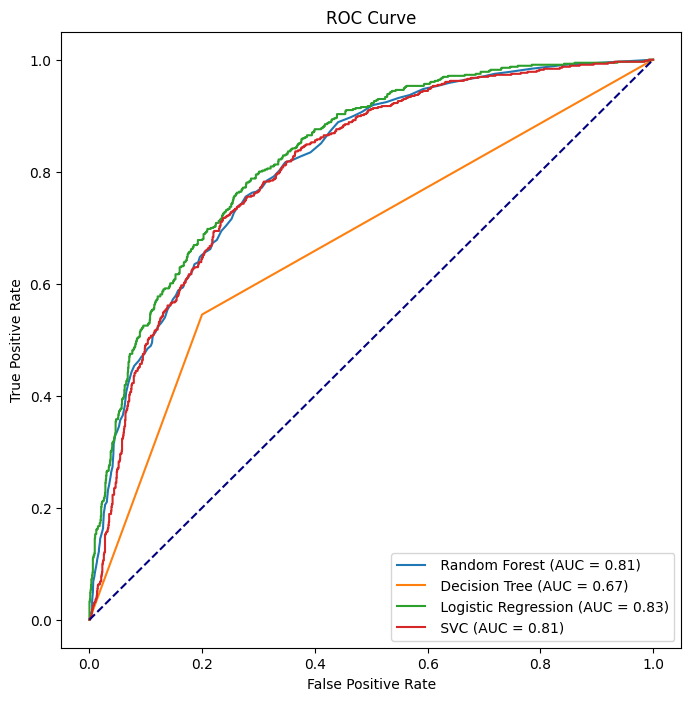

In [98]:
roc_curve_data = {} 

fig, ax = plt.subplots(figsize = (8,8)) 

for name, model in models.items(): 
    y_pred_proba = model.predict_proba(X_eval)[:, 1] 
    fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba) 
    roc_auc = roc_auc_score(y_eval, y_pred_proba) 
    roc_curve_df = pd.DataFrame({ 
        'False Positive Rate': fpr, 
        'True Positive Rate': tpr, 
        'Threshold': thresholds, 
    }) 
    roc_curve_data [name] = roc_curve_df 
    ax.plot (fpr, tpr, label = f' {name} (AUC = {roc_auc:.2f})') 

# Set the title and labels 
ax.plot([0,1],[0,1], color= 'navy', linestyle= '--',) 
ax.set_title("ROC Curve") 
ax.set_xlabel("False Positive Rate") 
ax.set_ylabel("True Positive Rate") 
ax.legend(loc="lower right") 

# Show the plot 
plt.show()



The AUC (Area Under the Receiver Operating Characteristic Curve) score represents the model's ability to distinguish between positive and negative classes. A higher AUC score indicates better performance.

Based on this comparison, Logistic Regression appears to be the best performer for the balanced data, followed closely by Random Forest and SVC. The Decision Tree model is the least effective of all the evaluation metrics.


**HyperParameter Tuning**

In [99]:
# Define the hyperparameter grids for each model:
    

param_grid_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': ['balanced', None]
}

param_grid_rf = {
    'classifier__max_depth': [5, 10, 15],
    'classifier__n_estimators': [50, 100, 200]
}

param_grid_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly']
}


In [100]:
# Perform hyperparameter tuning for each model using GridSearchCV:

grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='f1')
grid_search_lr.fit(X_eval, y_eval)

grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='f1')
grid_search_rf.fit(X_eval, y_eval)

grid_search_svc = GridSearchCV(svc_pipeline, param_grid_svc, cv=5, scoring='f1')
grid_search_svc.fit(X_eval, y_eval)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler()),
                                                                                         ('power-transformation',
                                                                                          PowerTransformer())]),
                                                                         ['tenure',
                                                                          'MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'PaperlessBilling']),
                                                                        ('cat',
                                                                         Pipeline(st...
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaymentMethod'])])),
                                       ('over-sampler', SMOTE(random_state=42)),
                                       ('feature_selection',
                                        SelectKBest(k='all',
                                                    score_func=<function mutual_info_classif at 0x000001B792CAE4D0>)),
                                       ('classifier',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__kernel': ['linear', 'rbf', 'poly']},
             scoring='f1')

In [101]:

# Get the best hyperparameters and best models for each model:

best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_
best_score_lr = grid_search_lr.best_score_

best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_
best_score_rf = grid_search_rf.best_score_

best_params_svc = grid_search_svc.best_params_
best_model_svc = grid_search_svc.best_estimator_
best_score_svc = grid_search_svc.best_score_

In [102]:
# Compare the best scores and select the model with the highest score as the best model:
def get_best_model(X, y):
    models = [best_model_lr, best_model_rf, best_model_svc]
    scores = []
    for model in models:
        score = cross_val_score(model, X, y, cv=5, scoring='f1').mean()
        scores.append(score)
    best_model_index = np.argmax(scores)
    return models[best_model_index]

best_model = get_best_model(X_eval, y_eval)

best_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('power-transformation',
                                                                   PowerTransformer())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImpute...
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('over-sampler', SMOTE(random_state=42)),
                ('feature_selection',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x000001B792CAE4D0>)),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=42))])

In [103]:
# Pass the best parameters back into the pipeline

best_params_rf = grid_search_rf.best_params_
rf_pipeline.set_params(**best_params_rf)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler()),
                                                                  ('power-transformation',
                                                                   PowerTransformer())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'PaperlessBilling']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImpute...
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaymentMethod'])])),
                ('over-sampler', SMOTE(random_state=42)),
                ('feature_selection',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x000001B792CAE4D0>)),
                ('classifier',
                 RandomForestClassifier(max_depth=5, random_state=42))])

#### **<span style="color: skyblue;">Model Testing</span>**

In [104]:
X_test = test_data[numeric_columns + categorical_columns]

In [105]:
y_pred = rf_pipeline.predict(X_test)

y_pred

array([1, 0, 0, ..., 1, 0, 0])

The predicted output (y_pred) is an array of 0s and 1s, where:

- 0 indicates a prediction of "no churn" (false)
- 1 indicates a prediction of "churn" (true/yes)

While I don't have the actual churn labels for the testing dataset, these predictions enable the identification of high-risk customers and informed retention strategies.

By applying the trained model to new, unseen data, I demonstrate its capability to generalize and make accurate predictions, a crucial aspect of machine learning model deployment.